# Network Science: Final Project

## Initialization

This includes:   
* Importing libraries
* Defining functions
* Loading data

### libraries

In [52]:
import networkx as nx #network analysis
import numpy as np 
import matplotlib.pyplot as plt #viz
import random 
import pandas as pd #to manipulate data frames
import math #for logarithm in entropy formula
from IPython.display import display
import os #files manipulation
import time #to measure time

#if you're working on google colab, uncomment the following line

# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/My Drive/net-sci-project-master/net-sci-project-master/code')
# os.getwcd()

### functions

Functions to:  
* compute LCC
* compute I index
* compute R measure
* compute Interval E
* Apply Random Attack
* Apply Targeted Attack (takes a graph and sorted list of nodes and returns dictions of metrics: LCC, I, efficiency)
* Apply Community ased attack

In [55]:
def compute_lcc(G):
    if G.number_of_nodes() == 0:
        return 0
    else:
        max_comp= max(nx.connected_components(G), key=len)
        return len(max_comp)
    
def compute_i(G, i):
    if G.number_of_nodes() == 0:
        return 0
    else:
        max_comp= max(nx.connected_components(G), key=len)
        return len(max_comp)/i

def compute_r(g, sorted_nodes):
    G=g.copy()
    SUM=0
    N= G.number_of_nodes()

    if type(sorted_nodes[0])==tuple:

        for i in range(N):

            n=sorted_nodes[i][0]
            G.remove_node(n)
            lcc= compute_lcc(G)/N
            SUM+=lcc
    else:
        for i in range(N):

            n=sorted_nodes[i]
            G.remove_node(n)
            lcc= compute_lcc(G)/N
            SUM+=lcc

    return SUM/N

def compute_r_50_batches(attack):
    '''takes a tuple of dictionaries (output of attack) that contains the lcc of attack'''
    lcc_attack=attack[3]
    r = sum(list(lcc_attack.values()))/len(list(lcc_attack.values()))
    return r

def compute_r_100_batches(g, sorted_nodes):
    G=g.copy()
    N=G.number_of_nodes()
    batch_size = N//100
    SUM=0
    if type(sorted_nodes[0])==tuple:

        for i in range(50):
            for j in range(batch_size):
                n = sorted_nodes[i*batch_size+j][0]
                G.remove_node(n)
            lcc = compute_lcc(G)/N
            SUM+=lcc
    
    else:
        for i in range(50):
            for j in range(batch_size):
                n = sorted_nodes[i*batch_size+j]
                G.remove_node(n)
            lcc = compute_lcc(G)/N
            SUM+=lcc

    return SUM/100


def random_attack(g):
    G=g.copy()
    nodes = list(G.nodes())
    random.shuffle(nodes)
    #divide the nodes into 100 batches
    fix=G.number_of_nodes()
    batch_size = fix//100
    LCC={}
    Inter={}
    E={}
    lcc_i = max([len(c) for c in nx.connected_components(G)])
    t=time.time()

    for i in range(50):
        for j in range(batch_size):
            n = nodes[i*batch_size+j]
            G.remove_node(n)
        lcc = compute_lcc(G)
        i_index= compute_i(G, lcc_i)
        LCC[i] = lcc/fix
        Inter[i]=i_index
        E[i]=nx.algorithms.global_efficiency(G)
    e=time.time()
    t=t-e
    return LCC, Inter, E, t

def random_attack_edge(g):
    '''returns the graph after a random attack of the edge'''
    G = g.copy()
    edges = list(G.edges())
    random.shuffle(edges)
    fix=G.number_of_nodes()
    batch_size = fix//100
    LCC={}
    Inter={}
    E={}
    lcc_i = max([len(c) for c in nx.connected_components(G)])
    t=time.time()

    for i in range(50):
        for j in range(batch_size):
            e = edges[i*batch_size+j]
            G.remove_edge(e[0], e[1])
        lcc = compute_lcc(G)
        i_index= compute_i(G, lcc_i)
        LCC[i] = lcc/fix
        Inter[i]=i_index
        E[i]=nx.algorithms.global_efficiency(G)

    e=time.time()
    t=t-e
    return LCC, Inter, E, t

def attack(g, sorted_nodes):
    G=g.copy()
    fix=G.number_of_nodes()
    batch_size = fix//100
    norm_LCC={}
    LCC={}
    Inter={}
    E={}
    lcc_i = max([len(c) for c in nx.connected_components(G)])
    t=time.time()

    for i in range(50):
        for j in range(batch_size):
            n = sorted_nodes[i*batch_size+j]
            G.remove_node(n)
        lcc = compute_lcc(G)
        i_index= compute_i(G, lcc_i)
        norm_LCC[i] = lcc/fix
        LCC[i]=lcc
        Inter[i]=i_index
        E[i]=nx.algorithms.global_efficiency(G)

    e=time.time()
    t=t-e
    return norm_LCC, Inter, E, LCC, t

def greedy_list(g) ->list:
    '''takes a graph and computes a list of node that follows the greedy attack scheme
    Get an initial list of best nodes to attack - network of n nodes, try n times:
        Copy the network in a new test network
        Remove a node from the test
        Assess robustness score after its removal
    Do this for the n nodes, sort them by order of most impactful attacks and emply the sequential 
    '''
    n=g.number_of_nodes()
    nodes=list(g.nodes())
    stat={}
    for i in range(n):
        G=g.copy()
        G.remove_node(nodes[i])
        lcc=compute_lcc(G)
        stat[nodes[i]]=lcc
    #sort the nodes keys in ascending order of their values in the dictionary
    nodes_sorted =  sorted(stat.items(), key=lambda x: x[1], reverse=False) 
    #get only the keys 
    nodes_sorted_list = [x[0] for x in nodes_sorted]
    return nodes_sorted_list

def get_MEB(G:nx.Graph, k:int, bet:dict)->float:
    '''
    takes a graph and a node k, returns the MEB centrality following this formula:
    MEBk= BCk * SUM(log(BCi)) for all i neighbor of k
    '''
    BCk = bet[k][1]
    neighbors = list(G.neighbors(k))
    BC_neighbors = [bet[x][1] for x in neighbors]
    sum_log_BC_neighbors = sum([math.log(x+1e-06) for x in BC_neighbors]) #if betweeness is 0, consider log(0)=-50
    MEBk = - BCk * sum_log_BC_neighbors
    return MEBk

def MEB_centrality(G:nx.Graph, bet)->dict:
    '''takes a graph and returns a dictionary of MEB centrality for each node'''
    MEB = {}
    for node in G.nodes():
        MEB[node] = get_MEB(G, node, bet)
    return MEB

def MEC(G:nx.Graph, k:int, clos:dict)->float:
    '''
    takes a graph and a node k, returns the MEC centrality following this formula:
    MECk= - CCk * SUM(log(CCi)) for all i neighbor of k
    '''
    CCk = clos[k][1]
    neighbors = list(G.neighbors(k))
    CC_neighbors = [clos[x][1] for x in neighbors]
    sum_log_CC_neighbors = sum([math.log(x) for x in CC_neighbors]) 
    MECk = - CCk * sum_log_CC_neighbors
    return MECk

def MEC_centrality(G:nx.Graph, clos)->dict:
    '''takes a graph and returns a dictionary of MEC centrality for each node'''
    MEC_dict = {}
    for node in G.nodes():
        MEC_dict[node] = MEC(G, node, clos)
    return MEC_dict

def MED(G:nx.Graph, k:int, deg:dict)->float:
    '''
    takes a graph and a node k, returns the MED centrality following this formula:
    MEDk= - DEGk * SUM(log(DEGi)) for all i neighbor of k
    '''
    DEGk = deg[k][1]
    neighbors = list(G.neighbors(k))
    DEG_neighbors = [deg[x][1] for x in neighbors]
    sum_log_DEG_neighbors = sum([math.log(x) for x in DEG_neighbors]) #if betweeness is 0, consider log(0)=-50
    MEDk = - DEGk * sum_log_DEG_neighbors
    return MEDk

def MED_centrality(G:nx.Graph, deg)->dict:
    '''takes a graph and returns a dictionary of MED centrality for each node'''
    MED_dict = {}
    for node in G.nodes():
        MED_dict[node] = MED(G, node, deg)
    return MED_dict

def proximity(node, shortest_paths):
    '''
    takes a graph and a node, returns the proximity centrality of that node
    '''
    sum_of_shortest_paths = sum(shortest_paths[node])
    # print(sum_of_shortest_paths)
    sum_of_all_pairs_shortest_paths = sum(sum(shortest_paths))
    proximity = sum_of_all_pairs_shortest_paths / sum_of_shortest_paths 
    return proximity

def proximity_centrality(G:nx.Graph)->dict:
    '''takes a graph and returns a dictionary of proximity centrality for each node'''
    pr = {}
    shortest_paths = nx.floyd_warshall_numpy(G)
    for node in G.nodes():
        pr[node] = proximity(node, shortest_paths)
    return pr

### Loading networks

* Loading the network
* Extract some properties:
  * Compute statistics
  * Get degree distribution

In [6]:
arenas_email = nx.read_gml('../benchmark/arenas-email.gml', label='id')
bn_cat_mixed_species_brain_1 = nx.read_gml('../benchmark/bn-cat-mixed-species_brain_1.gml', label='id')
bn_macaque_rhesus_brain_2 = nx.read_gml('../benchmark/bn-macaque-rhesus_brain_2.gml', label='id')
circuits_s208 = nx.read_gml('../benchmark/circuits s208.gml', label='id')
circuits_s420 = nx.read_gml('../benchmark/circuits s420.gml', label='id')
circuits_s838 = nx.read_gml('../benchmark/circuits s838.gml', label='id')
dolphins = nx.read_gml('../benchmark/dolphins.gml', label='id')
e_coli = nx.read_gml('../benchmark/E. coli.gml', label='id')
facebook_0 = nx.read_gml('../benchmark/facebook 0.gml', label='id')
facebook_107 = nx.read_gml('../benchmark/facebook 107.gml', label='id')
facebook_1684 = nx.read_gml('../benchmark/facebook 1684.gml', label='id')
facebook_348 = nx.read_gml('../benchmark/facebook 348.gml', label='id')
facebook_414 = nx.read_gml('../benchmark/facebook 414.gml', label='id')
facebook_686 = nx.read_gml('../benchmark/facebook 686.gml', label='id')
fb_pages_food = nx.read_gml('../benchmark/fb-pages-food.gml', label='id')
karate = nx.read_gml('../benchmark/Karate.gml', label='id')
polbooks = nx.read_gml('../benchmark/polbooks.gml', label='id')
soc_firm_hi_tech = nx.read_gml('../benchmark/soc-firm-hi-tech.gml', label='id')
soc_tribes = nx.read_gml('../benchmark/soc-tribes.gml', label='id')
word_adjacencies = nx.read_gml('../benchmark/word_adjacencies.gml', label='id')

net_911=nx.read_gml('../benchmark/911.gml', label='id')
corruption=nx.read_gml('../benchmark/corruption.gml', label='id')
crime_net=nx.read_gml('../benchmark/CrimeNet.gml', label='id')
digg=nx.read_gml('../benchmark/Digg.gml', label='id')
email=nx.read_gml('../benchmark/Email.gml', label='id')
jazz=nx.read_gml('../benchmark/Jazz.gml', label='id')
petster_hamster=nx.read_gml('../benchmark/Petster-Hamster.gml', label='id')
router=nx.read_gml('../benchmark/Router.gml', label='id')

## Attacks

### Random Attack

Random attacks applied to all the networks, all are divided to 100 batches, attack is up to 50% of the nodes/edges:
* nodes attacks 
* edges attacks

In [ ]:
#--------------------------------------------------------------------------------------------------------------#
#nodes random attacks:

random_arenas_email_attack = random_attack(arenas_email)
random_bn_cat_mixed_species_brain_1_attack = random_attack(bn_cat_mixed_species_brain_1)
random_bn_macaque_rhesus_brain_2_attack = random_attack(bn_macaque_rhesus_brain_2)
random_circuits_s208_attack = random_attack(circuits_s208)
random_circuits_s420_attack = random_attack(circuits_s420)
random_circuits_s838_attack = random_attack(circuits_s838)
random_dolphins_attack = random_attack(dolphins)
random_e_coli_attack = random_attack(e_coli)
random_facebook_0_attack = random_attack(facebook_0)
random_facebook_107_attack = random_attack(facebook_107)
random_facebook_1684_attack = random_attack(facebook_1684)
random_facebook_348_attack = random_attack(facebook_348)
random_facebook_414_attack = random_attack(facebook_414)
random_facebook_686_attack = random_attack(facebook_686)
random_fb_pages_food_attack = random_attack(fb_pages_food)
random_karate_attack = random_attack(karate)
random_polbooks_attack = random_attack(polbooks)
random_soc_firm_hi_tech_attack = random_attack(soc_firm_hi_tech)
random_soc_tribes_attack = random_attack(soc_tribes)
random_word_adjacencies_attack = random_attack(word_adjacencies)

random_net911_attack = random_attack(net_911)
random_corruption_attack = random_attack(corruption)
random_crime_net_attack = random_attack(crime_net)
random_email_attack = random_attack(email)
random_jazz_attack = random_attack(jazz)
random_petster_hamster_attack = random_attack(petster_hamster)
random_router_attack = random_attack(router)
# random_digg_attack = random_attack(digg)

#--------------------------------------------------------------------------------------------------------------#
#edges random attacks:

random_arenas_email_attack_edge= random_attack_edge(arenas_email)
random_bn_cat_mixed_species_brain_1_attack_edge= random_attack_edge(bn_cat_mixed_species_brain_1)
random_bn_macaque_rhesus_brain_2_attack_edge= random_attack_edge(bn_macaque_rhesus_brain_2)
random_circuits_s208_attack_edge= random_attack_edge(circuits_s208)
random_circuits_s420_attack_edge= random_attack_edge(circuits_s420)
random_circuits_s838_attack_edge= random_attack_edge(circuits_s838)
random_dolphins_attack_edge= random_attack_edge(dolphins)
random_e_coli_attack_edge= random_attack_edge(e_coli)
random_facebook_0_attack_edge= random_attack_edge(facebook_0)
random_facebook_107_attack_edge= random_attack_edge(facebook_107)
random_facebook_1684_attack_edge= random_attack_edge(facebook_1684)
random_facebook_348_attack_edge= random_attack_edge(facebook_348)
random_facebook_414_attack_edge= random_attack_edge(facebook_414)
random_facebook_686_attack_edge= random_attack_edge(facebook_686)
random_fb_pages_food_attack_edge= random_attack_edge(fb_pages_food)
random_karate_attack_edge= random_attack_edge(karate)
random_polbooks_attack_edge= random_attack_edge(polbooks)
random_soc_firm_hi_tech_attack_edge= random_attack_edge(soc_firm_hi_tech)
random_soc_tribes_attack_edge= random_attack_edge(soc_tribes)
random_word_adjacencies_attack_edge= random_attack_edge(word_adjacencies)

random_net911_attack_edge= random_attack_edge(net_911)
random_corruption_attack_edge= random_attack_edge(corruption)
random_crime_net_attack_edge= random_attack_edge(crime_net)
random_email_attack_edge= random_attack_edge(email)
random_jazz_attack_edge= random_attack_edge(jazz)
random_petster_hamster_attack_edge= random_attack_edge(petster_hamster)
random_router_attack_edge= random_attack_edge(router)
# random_digg_attack_edge= random_attack_edge(digg)

#--------------------------------------------------------------------------------------------------------------#

### Greedy Attack

Greedy attacks tries the removing each node from the original network, and ranks them based on how much they affeted the network from the first node removal. This ranking is used to remove nodes from the network. The attack is up to 50% of the nodes, it's greedy because it removes the nodes that have the most effect on the network - no recalculation becuase it becomes computationally expensive.

In [ ]:
arenas_email_greedy_attack = attack(arenas_email,greedy_list(arenas_email))
bn_cat_mixed_species_brain_1_greedy_attack = attack(bn_cat_mixed_species_brain_1,greedy_list(bn_cat_mixed_species_brain_1))
bn_macaque_rhesus_brain_2_greedy_attack = attack(bn_macaque_rhesus_brain_2,greedy_list(bn_macaque_rhesus_brain_2))
circuits_s208_greedy_attack = attack(circuits_s208,greedy_list(circuits_s208))
circuits_s420_greedy_attack = attack(circuits_s420,greedy_list(circuits_s420))
circuits_s838_greedy_attack = attack(circuits_s838,greedy_list(circuits_s838))
# dolphins_greedy_attack = attack(dolphins,greedy_list(dolphins))
e_coli_greedy_attack = attack(e_coli,greedy_list(e_coli))
facebook_0_greedy_attack = attack(facebook_0,greedy_list(facebook_0))
facebook_107_greedy_attack = attack(facebook_107,greedy_list(facebook_107))
facebook_1684_greedy_attack = attack(facebook_1684,greedy_list(facebook_1684))
facebook_348_greedy_attack = attack(facebook_348,greedy_list(facebook_348))
facebook_414_greedy_attack = attack(facebook_414,greedy_list(facebook_414))
facebook_686_greedy_attack = attack(facebook_686,greedy_list(facebook_686))
# fb_pages_food_greedy_attack = attack(fb_pages_food,greedy_list(fb_pages_food))
# karate_greedy_attack = attack(karate,greedy_list(karate))
polbooks_greedy_attack = attack(polbooks,greedy_list(polbooks))
# soc_firm_hi_tech_greedy_attack = attack(soc_firm_hi_tech,greedy_list(soc_firm_hi_tech))
# soc_tribes_greedy_attack = attack(soc_tribes,greedy_list(soc_tribes))
word_adjacencies_greedy_attack = attack(word_adjacencies,greedy_list(word_adjacencies))
net_911_greedy_attack = attack(net_911,greedy_list(net_911))
corruption_greedy_attack = attack(corruption,greedy_list(corruption))
crime_net_greedy_attack = attack(crime_net,greedy_list(crime_net))
email_greedy_attack = attack(email,greedy_list(email))
jazz_greedy_attack = attack(jazz,greedy_list(jazz))
petster_hamster_greedy_attack = attack(petster_hamster,greedy_list(petster_hamster))
# router_greedy_attack = attack(router,greedy_list(router))
# digg_greedy_attack = attack(digg,greedy_list(digg))


### Centrality-based Targeted Attack
---------------------------

* Nodes centralities:
  * Betweenness centrality
  * Closeness centrality
  * Degree centrality
  * PLCi centrality
  * Percolaion centrality
  * Proximity centrality
  * Mapping Entropy Betweenness centrality
  * Mapping Entropy Closeness centrality
  * Mapping Entropy Degree centrality   

----------------
<!--
* Edges centralities:
  * Betweenness centrality


-----------------
-->

#### Node centralities:

In [10]:
betweenness_centrality_sorted_arenas_email = sorted(nx.betweenness_centrality(arenas_email).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_bn_cat_mixed_species_brain_1 = sorted(nx.betweenness_centrality(bn_cat_mixed_species_brain_1).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_bn_macaque_rhesus_brain_2 = sorted(nx.betweenness_centrality(bn_macaque_rhesus_brain_2).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_circuits_s208 = sorted(nx.betweenness_centrality(circuits_s208).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_circuits_s420 = sorted(nx.betweenness_centrality(circuits_s420).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_circuits_s838 = sorted(nx.betweenness_centrality(circuits_s838).items(), key=lambda x: x[1], reverse=True) 
# betweenness_centrality_sorted_dolphins = sorted(nx.betweenness_centrality(dolphins).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_e_coli = sorted(nx.betweenness_centrality(e_coli).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_facebook_0 = sorted(nx.betweenness_centrality(facebook_0).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_facebook_107 = sorted(nx.betweenness_centrality(facebook_107).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_facebook_1684 = sorted(nx.betweenness_centrality(facebook_1684).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_facebook_348 = sorted(nx.betweenness_centrality(facebook_348).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_facebook_414 = sorted(nx.betweenness_centrality(facebook_414).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_facebook_686 = sorted(nx.betweenness_centrality(facebook_686).items(), key=lambda x: x[1], reverse=True)
# betweenness_centrality_sorted_fb_pages_food = sorted(nx.betweenness_centrality(fb_pages_food).items(), key=lambda x: x[1], reverse=True)
# betweenness_centrality_sorted_karate = sorted(nx.betweenness_centrality(karate).items(), key=lambda x: x[1], reverse=True)   
betweenness_centrality_sorted_polbooks = sorted(nx.betweenness_centrality(polbooks).items(), key=lambda x: x[1], reverse=True)
# betweenness_centrality_sorted_soc_firm_hi_tech = sorted(nx.betweenness_centrality(soc_firm_hi_tech).items(), key=lambda x: x[1], reverse=True)
# betweenness_centrality_sorted_soc_tribes = sorted(nx.betweenness_centrality(soc_tribes).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_word_adjacencies = sorted(nx.betweenness_centrality(word_adjacencies).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_net911 = sorted(nx.betweenness_centrality(net_911).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_corruption = sorted(nx.betweenness_centrality(corruption).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_crime_net = sorted(nx.betweenness_centrality(crime_net).items(), key=lambda x: x[1], reverse=True)
# betweenness_centrality_sorted_digg = sorted(nx.betweenness_centrality(digg).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_jazz = sorted(nx.betweenness_centrality(jazz).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_petster_hamster = sorted(nx.betweenness_centrality(petster_hamster).items(), key=lambda x: x[1], reverse=True)
# betweenness_centrality_sorted_router = sorted(nx.betweenness_centrality(router).items(), key=lambda x: x[1], reverse=True)
betweenness_centrality_sorted_email = sorted(nx.betweenness_centrality(email).items(), key=lambda x: x[1], reverse=True)


closeness_centrality_sorted_arenas_email = sorted(nx.closeness_centrality(arenas_email).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_bn_cat_mixed_species_brain_1 = sorted(nx.closeness_centrality(bn_cat_mixed_species_brain_1).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_bn_macaque_rhesus_brain_2 = sorted(nx.closeness_centrality(bn_macaque_rhesus_brain_2).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_circuits_s208 = sorted(nx.closeness_centrality(circuits_s208).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_circuits_s420 = sorted(nx.closeness_centrality(circuits_s420).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_circuits_s838 = sorted(nx.closeness_centrality(circuits_s838).items(), key=lambda x: x[1], reverse=True) 
# closeness_centrality_sorted_dolphins = sorted(nx.closeness_centrality(dolphins).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_e_coli = sorted(nx.closeness_centrality(e_coli).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_facebook_0 = sorted(nx.closeness_centrality(facebook_0).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_facebook_107 = sorted(nx.closeness_centrality(facebook_107).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_facebook_1684 = sorted(nx.closeness_centrality(facebook_1684).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_facebook_348 = sorted(nx.closeness_centrality(facebook_348).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_facebook_414 = sorted(nx.closeness_centrality(facebook_414).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_facebook_686 = sorted(nx.closeness_centrality(facebook_686).items(), key=lambda x: x[1], reverse=True)
# closeness_centrality_sorted_fb_pages_food = sorted(nx.closeness_centrality(fb_pages_food).items(), key=lambda x: x[1], reverse=True)
# closeness_centrality_sorted_karate = sorted(nx.closeness_centrality(karate).items(), key=lambda x: x[1], reverse=True)   
closeness_centrality_sorted_polbooks = sorted(nx.closeness_centrality(polbooks).items(), key=lambda x: x[1], reverse=True)
# closeness_centrality_sorted_soc_firm_hi_tech = sorted(nx.closeness_centrality(soc_firm_hi_tech).items(), key=lambda x: x[1], reverse=True)
# closeness_centrality_sorted_soc_tribes = sorted(nx.closeness_centrality(soc_tribes).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_word_adjacencies = sorted(nx.closeness_centrality(word_adjacencies).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_net911 = sorted(nx.closeness_centrality(net_911).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_corruption = sorted(nx.closeness_centrality(corruption).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_crime_net = sorted(nx.closeness_centrality(crime_net).items(), key=lambda x: x[1], reverse=True)
# closeness_centrality_sorted_digg = sorted(nx.closeness_centrality(digg).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_jazz = sorted(nx.closeness_centrality(jazz).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_petster_hamster = sorted(nx.closeness_centrality(petster_hamster).items(), key=lambda x: x[1], reverse=True)
# closeness_centrality_sorted_router = sorted(nx.closeness_centrality(router).items(), key=lambda x: x[1], reverse=True)
closeness_centrality_sorted_email = sorted(nx.closeness_centrality(email).items(), key=lambda x: x[1], reverse=True)


degree_centrality_sorted_arenas_email = sorted(nx.degree_centrality(arenas_email).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_bn_cat_mixed_species_brain_1 = sorted(nx.degree_centrality(bn_cat_mixed_species_brain_1).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_bn_macaque_rhesus_brain_2 = sorted(nx.degree_centrality(bn_macaque_rhesus_brain_2).items(), key=lambda x: x[1], reverse=True) 
degree_centrality_sorted_circuits_s208 = sorted(nx.degree_centrality(circuits_s208).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_circuits_s420 = sorted(nx.degree_centrality(circuits_s420).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_circuits_s838 = sorted(nx.degree_centrality(circuits_s838).items(), key=lambda x: x[1], reverse=True)
# degree_centrality_sorted_dolphins = sorted(nx.degree_centrality(dolphins).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_e_coli = sorted(nx.degree_centrality(e_coli).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_facebook_0 = sorted(nx.degree_centrality(facebook_0).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_facebook_107 = sorted(nx.degree_centrality(facebook_107).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_facebook_1684 = sorted(nx.degree_centrality(facebook_1684).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_facebook_348 = sorted(nx.degree_centrality(facebook_348).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_facebook_414 = sorted(nx.degree_centrality(facebook_414).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_facebook_686 = sorted(nx.degree_centrality(facebook_686).items(), key=lambda x: x[1], reverse=True)
# degree_centrality_sorted_fb_pages_food = sorted(nx.degree_centrality(fb_pages_food).items(), key=lambda x: x[1], reverse=True)
# degree_centrality_sorted_karate = sorted(nx.degree_centrality(karate).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_polbooks = sorted(nx.degree_centrality(polbooks).items(), key=lambda x: x[1], reverse=True)
# degree_centrality_sorted_soc_firm_hi_tech = sorted(nx.degree_centrality(soc_firm_hi_tech).items(), key=lambda x: x[1], reverse=True)
# degree_centrality_sorted_soc_tribes = sorted(nx.degree_centrality(soc_tribes).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_word_adjacencies = sorted(nx.degree_centrality(word_adjacencies).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_net911 = sorted(nx.degree_centrality(net_911).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_corruption = sorted(nx.degree_centrality(corruption).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_crime_net = sorted(nx.degree_centrality(crime_net).items(), key=lambda x: x[1], reverse=True)
# degree_centrality_sorted_digg = sorted(nx.degree_centrality(digg).items(), key=lambda x: x[1], reverse=True)
degree_centrality_jazz = sorted(nx.degree_centrality(jazz).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_petster_hamster = sorted(nx.degree_centrality(petster_hamster).items(), key=lambda x: x[1], reverse=True)
# degree_centrality_sorted_router = sorted(nx.degree_centrality(router).items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted_email = sorted(nx.degree_centrality(email).items(), key=lambda x: x[1], reverse=True)


bet_attack_arenas_email = attack(arenas_email, [x[0] for x in betweenness_centrality_sorted_arenas_email])
bet_attack_bn_cat_mixed_species_brain_1 = attack(bn_cat_mixed_species_brain_1, [x[0] for x in betweenness_centrality_sorted_bn_cat_mixed_species_brain_1])
bet_attack_bn_macaque_rhesus_brain_2 = attack(bn_macaque_rhesus_brain_2, [x[0] for x in betweenness_centrality_sorted_bn_macaque_rhesus_brain_2])
bet_attack_circuits_s208 = attack(circuits_s208, [x[0] for x in betweenness_centrality_sorted_circuits_s208])
bet_attack_circuits_s420 = attack(circuits_s420, [x[0] for x in betweenness_centrality_sorted_circuits_s420])
bet_attack_circuits_s838 = attack(circuits_s838, [x[0] for x in betweenness_centrality_sorted_circuits_s838])
# bet_attack_dolphins = attack(dolphins, [x[0] for x in betweenness_centrality_sorted_dolphins])
bet_attack_e_coli = attack(e_coli, [x[0] for x in betweenness_centrality_sorted_e_coli])
bet_attack_facebook_0 = attack(facebook_0, [x[0] for x in betweenness_centrality_sorted_facebook_0])
bet_attack_facebook_107 = attack(facebook_107, [x[0] for x in betweenness_centrality_sorted_facebook_107])
bet_attack_facebook_1684 = attack(facebook_1684, [x[0] for x in betweenness_centrality_sorted_facebook_1684])
bet_attack_facebook_348 = attack(facebook_348, [x[0] for x in betweenness_centrality_sorted_facebook_348])
bet_attack_facebook_414 = attack(facebook_414, [x[0] for x in betweenness_centrality_sorted_facebook_414])
bet_attack_facebook_686 = attack(facebook_686, [x[0] for x in betweenness_centrality_sorted_facebook_686])
# bet_attack_fb_pages_food = attack(fb_pages_food, [x[0] for x in betweenness_centrality_sorted_fb_pages_food])
# bet_attack_karate = attack(karate, [x[0] for x in betweenness_centrality_sorted_karate])
bet_attack_polbooks = attack(polbooks, [x[0] for x in betweenness_centrality_sorted_polbooks])
# bet_attack_soc_firm_hi_tech = attack(soc_firm_hi_tech, [x[0] for x in betweenness_centrality_sorted_soc_firm_hi_tech])
# bet_attack_soc_tribes = attack(soc_tribes, [x[0] for x in betweenness_centrality_sorted_soc_tribes])
bet_attack_word_adjacencies = attack(word_adjacencies, [x[0] for x in betweenness_centrality_sorted_word_adjacencies])
bet_attack_net911 = attack(net_911, [x[0] for x in betweenness_centrality_sorted_net911])
bet_attack_corruption = attack(corruption, [x[0] for x in betweenness_centrality_sorted_corruption])
bet_attack_crime_net = attack(crime_net, [x[0] for x in betweenness_centrality_sorted_crime_net])
# bet_attack_digg = attack(digg, [x[0] for x in betweenness_centrality_sorted_digg])
bet_attack_jazz = attack(jazz, [x[0] for x in betweenness_centrality_jazz])
bet_attack_petster_hamster = attack(petster_hamster, [x[0] for x in betweenness_centrality_sorted_petster_hamster])
# bet_attack_router = attack(router, [x[0] for x in betweenness_centrality_sorted_router])
bet_attack_email = attack(email, [x[0] for x in betweenness_centrality_sorted_email])

clos_attack_arenas_email = attack(arenas_email, [x[0] for x in closeness_centrality_sorted_arenas_email])
clos_attack_bn_cat_mixed_species_brain_1 = attack(bn_cat_mixed_species_brain_1, [x[0] for x in closeness_centrality_sorted_bn_cat_mixed_species_brain_1])
clos_attack_bn_macaque_rhesus_brain_2 = attack(bn_macaque_rhesus_brain_2, [x[0] for x in closeness_centrality_sorted_bn_macaque_rhesus_brain_2])
clos_attack_circuits_s208 = attack(circuits_s208, [x[0] for x in closeness_centrality_sorted_circuits_s208])
clos_attack_circuits_s420 = attack(circuits_s420, [x[0] for x in closeness_centrality_sorted_circuits_s420])
clos_attack_circuits_s838 = attack(circuits_s838, [x[0] for x in closeness_centrality_sorted_circuits_s838])
# clos_attack_dolphins = attack(dolphins, [x[0] for x in closeness_centrality_sorted_dolphins])
clos_attack_e_coli = attack(e_coli, [x[0] for x in closeness_centrality_sorted_e_coli])
clos_attack_facebook_0 = attack(facebook_0, [x[0] for x in closeness_centrality_sorted_facebook_0])
clos_attack_facebook_107 = attack(facebook_107, [x[0] for x in closeness_centrality_sorted_facebook_107])
clos_attack_facebook_1684 = attack(facebook_1684, [x[0] for x in closeness_centrality_sorted_facebook_1684])
clos_attack_facebook_348 = attack(facebook_348, [x[0] for x in closeness_centrality_sorted_facebook_348])
clos_attack_facebook_414 = attack(facebook_414, [x[0] for x in closeness_centrality_sorted_facebook_414])
clos_attack_facebook_686 = attack(facebook_686, [x[0] for x in closeness_centrality_sorted_facebook_686])
# clos_attack_fb_pages_food = attack(fb_pages_food, [x[0] for x in closeness_centrality_sorted_fb_pages_food])
# clos_attack_karate = attack(karate, [x[0] for x in closeness_centrality_sorted_karate])
clos_attack_polbooks = attack(polbooks, [x[0] for x in closeness_centrality_sorted_polbooks])
# clos_attack_soc_firm_hi_tech = attack(soc_firm_hi_tech, [x[0] for x in closeness_centrality_sorted_soc_firm_hi_tech])
# clos_attack_soc_tribes = attack(soc_tribes, [x[0] for x in closeness_centrality_sorted_soc_tribes])
clos_attack_word_adjacencies = attack(word_adjacencies, [x[0] for x in closeness_centrality_sorted_word_adjacencies])
clos_attack_net911 = attack(net_911, [x[0] for x in closeness_centrality_sorted_net911])
clos_attack_corruption = attack(corruption, [x[0] for x in closeness_centrality_sorted_corruption])
clos_attack_crime_net = attack(crime_net, [x[0] for x in closeness_centrality_sorted_crime_net])
# clos_attack_digg = attack(digg, [x[0] for x in closeness_centrality_sorted_digg])
clos_attack_jazz = attack(jazz, [x[0] for x in closeness_centrality_jazz])
clos_attack_petster_hamster = attack(petster_hamster, [x[0] for x in closeness_centrality_sorted_petster_hamster])
# clos_attack_router = attack(router, [x[0] for x in closeness_centrality_sorted_router])
clos_attack_email = attack(email, [x[0] for x in closeness_centrality_sorted_email])

deg_attack_arenas_email = attack(arenas_email, [x[0] for x in degree_centrality_sorted_arenas_email])
deg_attack_bn_cat_mixed_species_brain_1 = attack(bn_cat_mixed_species_brain_1, [x[0] for x in degree_centrality_sorted_bn_cat_mixed_species_brain_1])
deg_attack_bn_macaque_rhesus_brain_2 = attack(bn_macaque_rhesus_brain_2, [x[0] for x in degree_centrality_sorted_bn_macaque_rhesus_brain_2])
deg_attack_circuits_s208 = attack(circuits_s208, [x[0] for x in degree_centrality_sorted_circuits_s208])
deg_attack_circuits_s420 = attack(circuits_s420, [x[0] for x in degree_centrality_sorted_circuits_s420])
deg_attack_circuits_s838 = attack(circuits_s838, [x[0] for x in degree_centrality_sorted_circuits_s838])
# deg_attack_dolphins = attack(dolphins, [x[0] for x in degree_centrality_sorted_dolphins])
deg_attack_e_coli = attack(e_coli, [x[0] for x in degree_centrality_sorted_e_coli])
deg_attack_facebook_0 = attack(facebook_0, [x[0] for x in degree_centrality_sorted_facebook_0])
deg_attack_facebook_107 = attack(facebook_107, [x[0] for x in degree_centrality_sorted_facebook_107])
deg_attack_facebook_1684 = attack(facebook_1684, [x[0] for x in degree_centrality_sorted_facebook_1684])
deg_attack_facebook_348 = attack(facebook_348, [x[0] for x in degree_centrality_sorted_facebook_348])
deg_attack_facebook_414 = attack(facebook_414, [x[0] for x in degree_centrality_sorted_facebook_414])
deg_attack_facebook_686 = attack(facebook_686, [x[0] for x in degree_centrality_sorted_facebook_686])
# deg_attack_fb_pages_food = attack(fb_pages_food, [x[0] for x in degree_centrality_sorted_fb_pages_food])
# deg_attack_karate = attack(karate, [x[0] for x in degree_centrality_sorted_karate])
deg_attack_polbooks = attack(polbooks, [x[0] for x in degree_centrality_sorted_polbooks])
# deg_attack_soc_firm_hi_tech = attack(soc_firm_hi_tech, [x[0] for x in degree_centrality_sorted_soc_firm_hi_tech])
# deg_attack_soc_tribes = attack(soc_tribes, [x[0] for x in degree_centrality_sorted_soc_tribes])
deg_attack_word_adjacencies = attack(word_adjacencies, [x[0] for x in degree_centrality_sorted_word_adjacencies])
deg_attack_net911 = attack(net_911, [x[0] for x in degree_centrality_sorted_net911])
deg_attack_corruption = attack(corruption, [x[0] for x in degree_centrality_sorted_corruption])
deg_attack_crime_net = attack(crime_net, [x[0] for x in degree_centrality_sorted_crime_net])
# deg_attack_digg = attack(digg, [x[0] for x in degree_centrality_sorted_digg])
deg_attack_jazz = attack(jazz, [x[0] for x in degree_centrality_jazz])
deg_attack_petster_hamster = attack(petster_hamster, [x[0] for x in degree_centrality_sorted_petster_hamster])
# deg_attack_router = attack(router, [x[0] for x in degree_centrality_sorted_router])
deg_attack_email = attack(email, [x[0] for x in degree_centrality_sorted_email])



In [11]:
arenas_email_complex_df = pd.read_csv('../results/arenas_email.csv', skiprows=1, header=None)
plci_arenas_email = dict(zip(arenas_email_complex_df[0], arenas_email_complex_df[1]))
plci_arenas_email_sorted = sorted(plci_arenas_email.items(), key=lambda x: x[1], reverse=True)
plci_arenas_email_nodes =[x[0]-1 for x in plci_arenas_email_sorted]
percolation_arenas_email = dict(zip(arenas_email_complex_df[0], arenas_email_complex_df[2]))
percolation_arenas_email_sorted = sorted(percolation_arenas_email.items(), key=lambda x: x[1], reverse=True)
percolation_arenas_email_nodes =[x[0]-1 for x in percolation_arenas_email_sorted]

bn_cat_mixed_species_brain_1_complex_df = pd.read_csv('../results/bn_cat_mixed_species_brain_1.csv', skiprows=1, header=None)
plci_bn_cat_mixed_species_brain_1 = dict(zip(bn_cat_mixed_species_brain_1_complex_df[0], bn_cat_mixed_species_brain_1_complex_df[1]))
plci_bn_cat_mixed_species_brain_1_sorted = sorted(plci_bn_cat_mixed_species_brain_1.items(), key=lambda x: x[1], reverse=True)
plci_bn_cat_mixed_species_brain_1_nodes =[x[0]-1 for x in plci_bn_cat_mixed_species_brain_1_sorted]
percolation_bn_cat_mixed_species_brain_1 = dict(zip(bn_cat_mixed_species_brain_1_complex_df[0], bn_cat_mixed_species_brain_1_complex_df[2]))
percolation_bn_cat_mixed_species_brain_1_sorted = sorted(percolation_bn_cat_mixed_species_brain_1.items(), key=lambda x: x[1], reverse=True)
percolation_bn_cat_mixed_species_brain_1_nodes =[x[0]-1 for x in percolation_bn_cat_mixed_species_brain_1_sorted]

bn_macaque_rhesus_brain_2_complex_df = pd.read_csv('../results/bn_macaque_rhesus_brain_2.csv', skiprows=1, header=None)
plci_bn_macaque_rhesus_brain_2 = dict(zip(bn_macaque_rhesus_brain_2_complex_df[0], bn_macaque_rhesus_brain_2_complex_df[1]))
plci_bn_macaque_rhesus_brain_2_sorted = sorted(plci_bn_macaque_rhesus_brain_2.items(), key=lambda x: x[1], reverse=True)
plci_bn_macaque_rhesus_brain_2_nodes =[x[0]-1 for x in plci_bn_macaque_rhesus_brain_2_sorted]
percolation_bn_macaque_rhesus_brain_2 = dict(zip(bn_macaque_rhesus_brain_2_complex_df[0], bn_macaque_rhesus_brain_2_complex_df[2]))
percolation_bn_macaque_rhesus_brain_2_sorted = sorted(percolation_bn_macaque_rhesus_brain_2.items(), key=lambda x: x[1], reverse=True)
percolation_bn_macaque_rhesus_brain_2_nodes =[x[0]-1 for x in percolation_bn_macaque_rhesus_brain_2_sorted]

circuits_s208_complex_df = pd.read_csv('../results/circuits s208.csv', skiprows=1, header=None)
plci_circuits_s208 = dict(zip(circuits_s208_complex_df[0], circuits_s208_complex_df[1]))
plci_circuits_s208_sorted = sorted(plci_circuits_s208.items(), key=lambda x: x[1], reverse=True)
plci_circuits_s208_nodes =[x[0]-1 for x in plci_circuits_s208_sorted]
percolation_circuits_s208 = dict(zip(circuits_s208_complex_df[0], circuits_s208_complex_df[2]))
percolation_circuits_s208_sorted = sorted(percolation_circuits_s208.items(), key=lambda x: x[1], reverse=True)
percolation_circuits_s208_nodes =[x[0]-1 for x in percolation_circuits_s208_sorted]

circuits_s420_complex_df = pd.read_csv('../results/circuits s420.csv', skiprows=1, header=None)
plci_circuits_s420 = dict(zip(circuits_s420_complex_df[0], circuits_s420_complex_df[1]))
plci_circuits_s420_sorted = sorted(plci_circuits_s420.items(), key=lambda x: x[1], reverse=True)
plci_circuits_s420_nodes =[x[0]-1 for x in plci_circuits_s420_sorted]
percolation_circuits_s420 = dict(zip(circuits_s420_complex_df[0], circuits_s420_complex_df[2]))
percolation_circuits_s420_sorted = sorted(percolation_circuits_s420.items(), key=lambda x: x[1], reverse=True)
percolation_circuits_s420_nodes =[x[0]-1 for x in percolation_circuits_s420_sorted]

circuits_s838_complex_df = pd.read_csv('../results/circuits s838.csv', skiprows=1, header=None)
plci_circuits_s838 = dict(zip(circuits_s838_complex_df[0], circuits_s838_complex_df[1]))
plci_circuits_s838_sorted = sorted(plci_circuits_s838.items(), key=lambda x: x[1], reverse=True)
plci_circuits_s838_nodes =[x[0]-1 for x in plci_circuits_s838_sorted]
percolation_circuits_s838 = dict(zip(circuits_s838_complex_df[0], circuits_s838_complex_df[2]))
percolation_circuits_s838_sorted = sorted(percolation_circuits_s838.items(), key=lambda x: x[1], reverse=True)
percolation_circuits_s838_nodes =[x[0]-1 for x in percolation_circuits_s838_sorted]

# dolphins_complex_df = pd.read_csv('../results/resultsdolphins.csv', skiprows=1, header=None)
# plci_dolphins = dict(zip(dolphins_complex_df[0], dolphins_complex_df[1]))
# plci_dolphins_sorted = sorted(plci_dolphins.items(), key=lambda x: x[1], reverse=True)
# plci_dolphins_nodes =[x[0]-1 for x in plci_dolphins_sorted]
# percolation_dolphins = dict(zip(dolphins_complex_df[0], dolphins_complex_df[2]))
# percolation_dolphins_sorted = sorted(percolation_dolphins.items(), key=lambda x: x[1], reverse=True)
# percolation_dolphins_nodes =[x[0]-1 for x in percolation_dolphins_sorted]

e_coli_complex_df = pd.read_csv('../results/E. coli.csv', skiprows=1, header=None)
plci_e_coli = dict(zip(e_coli_complex_df[0], e_coli_complex_df[1]))
plci_e_coli_sorted = sorted(plci_e_coli.items(), key=lambda x: x[1], reverse=True)
plci_e_coli_nodes =[x[0]-1 for x in plci_e_coli_sorted]
percolation_e_coli = dict(zip(e_coli_complex_df[0], e_coli_complex_df[2]))
percolation_e_coli_sorted = sorted(percolation_e_coli.items(), key=lambda x: x[1], reverse=True)
percolation_e_coli_nodes =[x[0]-1 for x in percolation_e_coli_sorted]

facebook_0_complex_df = pd.read_csv('../results/facebook 0.csv', skiprows=1, header=None)
plci_facebook_0 = dict(zip(facebook_0_complex_df[0], facebook_0_complex_df[1]))
plci_facebook_0_sorted = sorted(plci_facebook_0.items(), key=lambda x: x[1], reverse=True)
plci_facebook_0_nodes =[x[0]-1 for x in plci_facebook_0_sorted]
percolation_facebook_0 = dict(zip(facebook_0_complex_df[0], facebook_0_complex_df[2]))
percolation_facebook_0_sorted = sorted(percolation_facebook_0.items(), key=lambda x: x[1], reverse=True)
percolation_facebook_0_nodes =[x[0]-1 for x in percolation_facebook_0_sorted]

facebook_107_complex_df = pd.read_csv('../results/facebook 107.csv', skiprows=1, header=None)
plci_facebook_107 = dict(zip(facebook_107_complex_df[0], facebook_107_complex_df[1]))
plci_facebook_107_sorted = sorted(plci_facebook_107.items(), key=lambda x: x[1], reverse=True)
plci_facebook_107_nodes =[x[0]-1 for x in plci_facebook_107_sorted]
percolation_facebook_107 = dict(zip(facebook_107_complex_df[0], facebook_107_complex_df[2]))
percolation_facebook_107_sorted = sorted(percolation_facebook_107.items(), key=lambda x: x[1], reverse=True)
percolation_facebook_107_nodes =[x[0]-1 for x in percolation_facebook_107_sorted]

facebook_1684_complex_df = pd.read_csv('../results/facebook 1684.csv', skiprows=1, header=None)
plci_facebook_1684 = dict(zip(facebook_1684_complex_df[0], facebook_1684_complex_df[1]))
plci_facebook_1684_sorted = sorted(plci_facebook_1684.items(), key=lambda x: x[1], reverse=True)
plci_facebook_1684_nodes =[x[0]-1 for x in plci_facebook_1684_sorted]
percolation_facebook_1684 = dict(zip(facebook_1684_complex_df[0], facebook_1684_complex_df[2]))
percolation_facebook_1684_sorted = sorted(percolation_facebook_1684.items(), key=lambda x: x[1], reverse=True)
percolation_facebook_1684_nodes =[x[0]-1 for x in percolation_facebook_1684_sorted]

facebook_348_complex_df = pd.read_csv('../results/facebook 348.csv', skiprows=1, header=None)
plci_facebook_348 = dict(zip(facebook_348_complex_df[0], facebook_348_complex_df[1]))
plci_facebook_348_sorted = sorted(plci_facebook_348.items(), key=lambda x: x[1], reverse=True)
plci_facebook_348_nodes =[x[0]-1 for x in plci_facebook_348_sorted]
percolation_facebook_348 = dict(zip(facebook_348_complex_df[0], facebook_348_complex_df[2]))
percolation_facebook_348_sorted = sorted(percolation_facebook_348.items(), key=lambda x: x[1], reverse=True)
percolation_facebook_348_nodes =[x[0]-1 for x in percolation_facebook_348_sorted]

facebook_414_complex_df = pd.read_csv('../results/facebook 414.csv', skiprows=1, header=None)
plci_facebook_414 = dict(zip(facebook_414_complex_df[0], facebook_414_complex_df[1]))
plci_facebook_414_sorted = sorted(plci_facebook_414.items(), key=lambda x: x[1], reverse=True)
plci_facebook_414_nodes =[x[0]-1 for x in plci_facebook_414_sorted]
percolation_facebook_414 = dict(zip(facebook_414_complex_df[0], facebook_414_complex_df[2]))
percolation_facebook_414_sorted = sorted(percolation_facebook_414.items(), key=lambda x: x[1], reverse=True)
percolation_facebook_414_nodes =[x[0]-1 for x in percolation_facebook_414_sorted]

facebook_686_complex_df = pd.read_csv('../results/facebook 686.csv', skiprows=1, header=None)
plci_facebook_686 = dict(zip(facebook_686_complex_df[0], facebook_686_complex_df[1]))
plci_facebook_686_sorted = sorted(plci_facebook_686.items(), key=lambda x: x[1], reverse=True)  
plci_facebook_686_nodes =[x[0]-1 for x in plci_facebook_686_sorted]
percolation_facebook_686 = dict(zip(facebook_686_complex_df[0], facebook_686_complex_df[2]))
percolation_facebook_686_sorted = sorted(percolation_facebook_686.items(), key=lambda x: x[1], reverse=True)    
percolation_facebook_686_nodes =[x[0]-1 for x in percolation_facebook_686_sorted]

# fb_pages_food_complex_df = pd.read_csv('../results/resultsfb_pages_food.csv', skiprows=1, header=None)
# plci_fb_pages_food = dict(zip(fb_pages_food_complex_df[0], fb_pages_food_complex_df[1]))
# plci_fb_pages_food_sorted = sorted(plci_fb_pages_food.items(), key=lambda x: x[1], reverse=True)
# plci_fb_pages_food_nodes =[x[0]-1 for x in plci_fb_pages_food_sorted]
# percolation_fb_pages_food = dict(zip(fb_pages_food_complex_df[0], fb_pages_food_complex_df[2]))
# percolation_fb_pages_food_sorted = sorted(percolation_fb_pages_food.items(), key=lambda x: x[1], reverse=True)
# percolation_fb_pages_food_nodes =[x[0]-1 for x in percolation_fb_pages_food_sorted]

# karate_complex_df = pd.read_csv('../results/resultskarate.csv', skiprows=1, header=None)
# plci_karate = dict(zip(karate_complex_df[0], karate_complex_df[1])) 
# plci_karate_sorted = sorted(plci_karate.items(), key=lambda x: x[1], reverse=True)
# plci_karate_nodes =[x[0]-1 for x in plci_karate_sorted]
# percolation_karate = dict(zip(karate_complex_df[0], karate_complex_df[2]))
# percolation_karate_sorted = sorted(percolation_karate.items(), key=lambda x: x[1], reverse=True)
# percolation_karate_nodes =[x[0]-1 for x in percolation_karate_sorted]

polbooks_complex_df = pd.read_csv('../results/polbooks.csv', skiprows=1, header=None)
plci_polbooks = dict(zip(polbooks_complex_df[0], polbooks_complex_df[1]))
plci_polbooks_sorted = sorted(plci_polbooks.items(), key=lambda x: x[1], reverse=True)
plci_polbooks_nodes =[x[0]-1 for x in plci_polbooks_sorted]
percolation_polbooks = dict(zip(polbooks_complex_df[0], polbooks_complex_df[2]))
percolation_polbooks_sorted = sorted(percolation_polbooks.items(), key=lambda x: x[1], reverse=True)
percolation_polbooks_nodes =[x[0]-1 for x in percolation_polbooks_sorted]

# soc_firm_hi_tech_complex_df = pd.read_csv('../results/resultssoc_firm_hi_tech.csv', skiprows=1, header=None)
# plci_soc_firm_hi_tech = dict(zip(soc_firm_hi_tech_complex_df[0], soc_firm_hi_tech_complex_df[1]))
# plci_soc_firm_hi_tech_sorted = sorted(plci_soc_firm_hi_tech.items(), key=lambda x: x[1], reverse=True)
# plci_soc_firm_hi_tech_nodes =[x[0]-1 for x in plci_soc_firm_hi_tech_sorted]
# percolation_soc_firm_hi_tech = dict(zip(soc_firm_hi_tech_complex_df[0], soc_firm_hi_tech_complex_df[2]))
# percolation_soc_firm_hi_tech_sorted = sorted(percolation_soc_firm_hi_tech.items(), key=lambda x: x[1], reverse=True)
# percolation_soc_firm_hi_tech_nodes =[x[0]-1 for x in percolation_soc_firm_hi_tech_sorted]

# soc_tribes_complex_df = pd.read_csv('../results/resultssoc_tribes.csv', skiprows=1, header=None)
# plci_soc_tribes = dict(zip(soc_tribes_complex_df[0], soc_tribes_complex_df[1]))
# plci_soc_tribes_sorted = sorted(plci_soc_tribes.items(), key=lambda x: x[1], reverse=True)
# plci_soc_tribes_nodes =[x[0]-1 for x in plci_soc_tribes_sorted]
# percolation_soc_tribes = dict(zip(soc_tribes_complex_df[0], soc_tribes_complex_df[2]))
# percolation_soc_tribes_sorted = sorted(percolation_soc_tribes.items(), key=lambda x: x[1], reverse=True)
# percolation_soc_tribes_nodes =[x[0]-1 for x in percolation_soc_tribes_sorted]

word_adjacencies_complex_df = pd.read_csv('../results/word_adjacencies.csv', skiprows=1, header=None)
plci_word_adjacencies = dict(zip(word_adjacencies_complex_df[0], word_adjacencies_complex_df[1]))
plci_word_adjacencies_sorted = sorted(plci_word_adjacencies.items(), key=lambda x: x[1], reverse=True)
plci_word_adjacencies_nodes =[x[0]-1 for x in plci_word_adjacencies_sorted]
percolation_word_adjacencies = dict(zip(word_adjacencies_complex_df[0], word_adjacencies_complex_df[2]))
percolation_word_adjacencies_sorted = sorted(percolation_word_adjacencies.items(), key=lambda x: x[1], reverse=True)
percolation_word_adjacencies_nodes =[x[0]-1 for x in percolation_word_adjacencies_sorted]

net_911_complex_df = pd.read_csv('../results/911.csv', skiprows=1, header=None)
plci_net_911 = dict(zip(net_911_complex_df[0], net_911_complex_df[1]))
plci_net_911_sorted = sorted(plci_net_911.items(), key=lambda x: x[1], reverse=True)
plci_net_911_nodes =[x[0]-1 for x in plci_net_911_sorted]
percolation_net_911 = dict(zip(net_911_complex_df[0], net_911_complex_df[2]))
percolation_net_911_sorted = sorted(percolation_net_911.items(), key=lambda x: x[1], reverse=True)
percolation_net_911_nodes =[x[0]-1 for x in percolation_net_911_sorted]

corruption_complex_df = pd.read_csv('../results/corruption.csv', skiprows=1, header=None)
plci_corruption = dict(zip(corruption_complex_df[0], corruption_complex_df[1]))
plci_corruption_sorted = sorted(plci_corruption.items(), key=lambda x: x[1], reverse=True)
plci_corruption_nodes =[x[0]-1 for x in plci_corruption_sorted]
percolation_corruption = dict(zip(corruption_complex_df[0], corruption_complex_df[2]))
percolation_corruption_sorted = sorted(percolation_corruption.items(), key=lambda x: x[1], reverse=True)
percolation_corruption_nodes =[x[0]-1 for x in percolation_corruption_sorted]

crime_net_complex_df = pd.read_csv('../results/CrimeNet.csv', skiprows=1, header=None)
plci_crime_net = dict(zip(crime_net_complex_df[0], crime_net_complex_df[1]))
plci_crime_net_sorted = sorted(plci_crime_net.items(), key=lambda x: x[1], reverse=True)
plci_crime_net_nodes =[x[0]-1 for x in plci_crime_net_sorted]
percolation_crime_net = dict(zip(crime_net_complex_df[0], crime_net_complex_df[2]))
percolation_crime_net_sorted = sorted(percolation_crime_net.items(), key=lambda x: x[1], reverse=True)
percolation_crime_net_nodes =[x[0]-1 for x in percolation_crime_net_sorted]

# digg_complex_df = pd.read_csv('../results/resultsdigg.csv', skiprows=1, header=None)
# plci_digg = dict(zip(digg_complex_df[0], digg_complex_df[1]))
# plci_digg_sorted = sorted(plci_digg.items(), key=lambda x: x[1], reverse=True)
# plci_digg_nodes =[x[0]-1 for x in plci_digg_sorted]
# percolation_digg = dict(zip(digg_complex_df[0], digg_complex_df[2]))
# percolation_digg_sorted = sorted(percolation_digg.items(), key=lambda x: x[1], reverse=True)
# percolation_digg_nodes =[x[0]-1 for x in percolation_digg_sorted]

jazz_complex_df = pd.read_csv('../results/Jazz.csv', skiprows=1, header=None)
plci_jazz = dict(zip(jazz_complex_df[0], jazz_complex_df[1]))
plci_jazz_sorted = sorted(plci_jazz.items(), key=lambda x: x[1], reverse=True)
plci_jazz_nodes =[x[0]-1 for x in plci_jazz_sorted]
percolation_jazz = dict(zip(jazz_complex_df[0], jazz_complex_df[2]))
percolation_jazz_sorted = sorted(percolation_jazz.items(), key=lambda x: x[1], reverse=True)
percolation_jazz_nodes =[x[0]-1 for x in percolation_jazz_sorted]

petstor_hamster_complex_df = pd.read_csv('../results/Petster_Hamster.csv', skiprows=1, header=None)
plci_petster_hamster = dict(zip(petstor_hamster_complex_df[0], petstor_hamster_complex_df[1]))
plci_petster_hamster_sorted = sorted(plci_petster_hamster.items(), key=lambda x: x[1], reverse=True)
plci_petster_hamster_nodes =[x[0]-1 for x in plci_petster_hamster_sorted]
percolation_petster_hamster = dict(zip(petstor_hamster_complex_df[0], petstor_hamster_complex_df[2]))
percolation_petster_hamster_sorted = sorted(percolation_petster_hamster.items(), key=lambda x: x[1], reverse=True)
percolation_petster_hamster_nodes =[x[0]-1 for x in percolation_petster_hamster_sorted]

# router_complex_df = pd.read_csv('../results/resultsrouter.csv', skiprows=1, header=None)
# plci_router = dict(zip(router_complex_df[0], router_complex_df[1]))
# plci_router_sorted = sorted(plci_router.items(), key=lambda x: x[1], reverse=True)
# plci_router_nodes =[x[0]-1 for x in plci_router_sorted]
# percolation_router = dict(zip(router_complex_df[0], router_complex_df[2]))
# percolation_router_sorted = sorted(percolation_router.items(), key=lambda x: x[1], reverse=True)
# percolation_router_nodes =[x[0]-1 for x in percolation_router_sorted]

email_complex_df = pd.read_csv('../results/Email.csv', skiprows=1, header=None)
plci_email = dict(zip(email_complex_df[0], email_complex_df[1]))
plci_email_sorted = sorted(plci_email.items(), key=lambda x: x[1], reverse=True)
plci_email_nodes =[x[0]-1 for x in plci_email_sorted]
percolation_email = dict(zip(email_complex_df[0], email_complex_df[2]))
percolation_email_sorted = sorted(percolation_email.items(), key=lambda x: x[1], reverse=True)
percolation_email_nodes =[x[0]-1 for x in percolation_email_sorted]

#------------------------------------------------------------------------------------------------------------------------------
#pcli attack

plci_attack_arenas_email = attack(arenas_email, plci_arenas_email_nodes)
plci_attack_bn_cat_mixed_species_brain_1 = attack(bn_cat_mixed_species_brain_1, plci_bn_cat_mixed_species_brain_1_nodes)
plci_attack_bn_macaque_rhesus_brain_2 = attack(bn_macaque_rhesus_brain_2, plci_bn_macaque_rhesus_brain_2_nodes)
plci_attack_circuits_s208 = attack(circuits_s208, plci_circuits_s208_nodes)
plci_attack_circuits_s420 = attack(circuits_s420, plci_circuits_s420_nodes)
plci_attack_circuits_s838 = attack(circuits_s838, plci_circuits_s838_nodes)
# plci_attack_dolphins = attack(dolphins, plci_dolphins_nodes)
plci_attack_e_coli = attack(e_coli, plci_e_coli_nodes)
plci_attack_facebook_0 = attack(facebook_0, plci_facebook_0_nodes)
plci_attack_facebook_107 = attack(facebook_107, plci_facebook_107_nodes)
plci_attack_facebook_1684 = attack(facebook_1684, plci_facebook_1684_nodes)
plci_attack_facebook_348 = attack(facebook_348, plci_facebook_348_nodes)
plci_attack_facebook_414 = attack(facebook_414, plci_facebook_414_nodes)
plci_attack_facebook_686 = attack(facebook_686, plci_facebook_686_nodes)
# plci_attack_fb_pages_food = attack(fb_pages_food, plci_fb_pages_food_nodes)
# plci_attack_karate = attack(karate, plci_karate_nodes)
plci_attack_polbooks = attack(polbooks, plci_polbooks_nodes)
# plci_attack_soc_firm_hi_tech = attack(soc_firm_hi_tech, plci_soc_firm_hi_tech_nodes)
# plci_attack_soc_tribes = attack(soc_tribes, plci_soc_tribes_nodes)
plci_attack_word_adjacencies = attack(word_adjacencies, plci_word_adjacencies_nodes)
plci_attack_net911 = attack(net_911, plci_net_911_nodes)
plci_attack_corruption = attack(corruption, plci_corruption_nodes)
plci_attack_crime_net = attack(crime_net, plci_crime_net_nodes)
# plci_attack_digg = attack(digg, plci_digg_nodes)
plci_attack_jazz = attack(jazz, plci_jazz_nodes)
plci_attack_petster_hamster = attack(petster_hamster, plci_petster_hamster_nodes)
# plci_attack_router = attack(router, plci_router_nodes)
plci_attack_email = attack(email, plci_email_nodes)

#------------------------------------------------------------------------------------------------------------------------------
#percolation attack

percolation_attack_arenas_email = attack(arenas_email, percolation_arenas_email_nodes)
percolation_attack_bn_cat_mixed_species_brain_1 = attack(bn_cat_mixed_species_brain_1, percolation_bn_cat_mixed_species_brain_1_nodes)
percolation_attack_bn_macaque_rhesus_brain_2 = attack(bn_macaque_rhesus_brain_2, percolation_bn_macaque_rhesus_brain_2_nodes)
percolation_attack_circuits_s208 = attack(circuits_s208, percolation_circuits_s208_nodes)
percolation_attack_circuits_s420 = attack(circuits_s420, percolation_circuits_s420_nodes)
percolation_attack_circuits_s838 = attack(circuits_s838, percolation_circuits_s838_nodes)
# percolation_attack_dolphins = attack(dolphins, percolation_dolphins_nodes)
percolation_attack_e_coli = attack(e_coli, percolation_e_coli_nodes)
percolation_attack_facebook_0 = attack(facebook_0, percolation_facebook_0_nodes)
percolation_attack_facebook_107 = attack(facebook_107, percolation_facebook_107_nodes)
percolation_attack_facebook_1684 = attack(facebook_1684, percolation_facebook_1684_nodes)
percolation_attack_facebook_348 = attack(facebook_348, percolation_facebook_348_nodes)
percolation_attack_facebook_414 = attack(facebook_414, percolation_facebook_414_nodes)
percolation_attack_facebook_686 = attack(facebook_686, percolation_facebook_686_nodes)
# percolation_attack_fb_pages_food = attack(fb_pages_food, percolation_fb_pages_food_nodes)
# percolation_attack_karate = attack(karate, percolation_karate_nodes)
percolation_attack_polbooks = attack(polbooks, percolation_polbooks_nodes)
# percolation_attack_soc_firm_hi_tech = attack(soc_firm_hi_tech, percolation_soc_firm_hi_tech_nodes)
# percolation_attack_soc_tribes = attack(soc_tribes, percolation_soc_tribes_nodes)
percolation_attack_word_adjacencies = attack(word_adjacencies, percolation_word_adjacencies_nodes)
percolation_attack_net911 = attack(net_911, percolation_net_911_nodes)
percolation_attack_corruption = attack(corruption, percolation_corruption_nodes)
percolation_attack_crime_net = attack(crime_net, percolation_crime_net_nodes)
# percolation_attack_digg = attack(digg, percolation_digg_nodes)
percolation_attack_jazz = attack(jazz, percolation_jazz_nodes)
percolation_attack_petster_hamster = attack(petster_hamster, percolation_petster_hamster_nodes)
# percolation_attack_router = attack(router, percolation_router_nodes)
percolation_attack_email = attack(email, percolation_email_nodes)


In [50]:
#proximity attack
proximity_centrality_sorted_arenas_email = sorted(proximity_centrality(arenas_email).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_arenas_email_nodes =[x[0] for x in proximity_centrality_sorted_arenas_email]
print("done arenas_email")
proximity_centrality_sorted_bn_cat_mixed_species_brain_1 = sorted(proximity_centrality(bn_cat_mixed_species_brain_1).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_bn_cat_mixed_species_brain_1_nodes =[x[0] for x in proximity_centrality_sorted_bn_cat_mixed_species_brain_1]
print("done bn_cat_mixed_species_brain_1")
proximity_centrality_sorted_bn_macaque_rhesus_brain_2 = sorted(proximity_centrality(bn_macaque_rhesus_brain_2).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_bn_macaque_rhesus_brain_2_nodes =[x[0] for x in proximity_centrality_sorted_bn_macaque_rhesus_brain_2]
print("done bn_macaque_rhesus_brain_2")
proximity_centrality_sorted_circuits_s208 = sorted(proximity_centrality(circuits_s208).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_circuits_s208_nodes =[x[0] for x in proximity_centrality_sorted_circuits_s208]
print("done circuits_s208")
proximity_centrality_sorted_circuits_s420 = sorted(proximity_centrality(circuits_s420).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_circuits_s420_nodes =[x[0] for x in proximity_centrality_sorted_circuits_s420]
print("done circuits_s420")
proximity_centrality_sorted_circuits_s838 = sorted(proximity_centrality(circuits_s838).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_circuits_s838_nodes =[x[0] for x in proximity_centrality_sorted_circuits_s838]
print("done circuits_s838")
# proximity_centrality_sorted_dolphins = sorted(proximity_centrality(dolphins).items(), key=lambda x: x[1], reverse=True)
# proximity_centrality_sorted_dolphins_nodes =[x[0] for x in proximity_centrality_sorted_dolphins]
# print("done dolphins")
proximity_centrality_sorted_e_coli = sorted(proximity_centrality(e_coli).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_e_coli_nodes =[x[0] for x in proximity_centrality_sorted_e_coli]
print("done e_coli")
proximity_centrality_sorted_facebook_0 = sorted(proximity_centrality(facebook_0).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_facebook_0_nodes =[x[0] for x in proximity_centrality_sorted_facebook_0]
print("done facebook_0")
proximity_centrality_sorted_facebook_107 = sorted(proximity_centrality(facebook_107).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_facebook_107_nodes =[x[0] for x in proximity_centrality_sorted_facebook_107]
print("done facebook_107")
proximity_centrality_sorted_facebook_1684 = sorted(proximity_centrality(facebook_1684).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_facebook_1684_nodes =[x[0] for x in proximity_centrality_sorted_facebook_1684]
print("done facebook_1684")
proximity_centrality_sorted_facebook_348 = sorted(proximity_centrality(facebook_348).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_facebook_348_nodes =[x[0] for x in proximity_centrality_sorted_facebook_348]
print("done facebook_348")
proximity_centrality_sorted_facebook_414 = sorted(proximity_centrality(facebook_414).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_facebook_414_nodes =[x[0] for x in proximity_centrality_sorted_facebook_414]
print("done facebook_414")
proximity_centrality_sorted_facebook_686 = sorted(proximity_centrality(facebook_686).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_facebook_686_nodes =[x[0] for x in proximity_centrality_sorted_facebook_686]
print("done facebook_686")
# proximity_centrality_sorted_fb_pages_food = sorted(proximity_centrality(fb_pages_food).items(), key=lambda x: x[1], reverse=True)
# proximity_centrality_sorted_fb_pages_food_nodes =[x[0] for x in proximity_centrality_sorted_fb_pages_food]
# print("done fb_pages_food")
# proximity_centrality_sorted_karate = sorted(proximity_centrality(karate).items(), key=lambda x: x[1], reverse=True)
# proximity_centrality_sorted_karate_nodes =[x[0] for x in proximity_centrality_sorted_karate]
# print("done karate")
proximity_centrality_sorted_polbooks = sorted(proximity_centrality(polbooks).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_polbooks_nodes =[x[0] for x in proximity_centrality_sorted_polbooks]
print("done polbooks")
# proximity_centrality_sorted_soc_firm_hi_tech = sorted(proximity_centrality(soc_firm_hi_tech).items(), key=lambda x: x[1], reverse=True)
# proximity_centrality_sorted_soc_firm_hi_tech_nodes =[x[0] for x in proximity_centrality_sorted_soc_firm_hi_tech]
# print("done soc_firm_hi_tech")
# proximity_centrality_sorted_soc_tribes = sorted(proximity_centrality(soc_tribes).items(), key=lambda x: x[1], reverse=True)
# proximity_centrality_sorted_soc_tribes_nodes =[x[0] for x in proximity_centrality_sorted_soc_tribes]
# print("done soc_tribes")
proximity_centrality_sorted_word_adjacencies = sorted(proximity_centrality(word_adjacencies).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_word_adjacencies_nodes =[x[0] for x in proximity_centrality_sorted_word_adjacencies]
print("done word_adjacencies")
proximity_centrality_sorted_net911 = sorted(proximity_centrality(net_911).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_net911_nodes =[x[0] for x in proximity_centrality_sorted_net911]
print("done net911")
proximity_centrality_sorted_corruption = sorted(proximity_centrality(corruption).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_corruption_nodes =[x[0] for x in proximity_centrality_sorted_corruption]
print("done corruption")
proximity_centrality_sorted_crime_net = sorted(proximity_centrality(crime_net).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_crime_net_nodes =[x[0] for x in proximity_centrality_sorted_crime_net]
print("done crime_net")
# proximity_centrality_sorted_digg = sorted(proximity_centrality(digg).items(), key=lambda x: x[1], reverse=True)
# proximity_centrality_sorted_digg_nodes =[x[0] for x in proximity_centrality_sorted_digg]
# print("done digg")
proximity_centrality_sorted_jazz = sorted(proximity_centrality(jazz).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_jazz_nodes =[x[0] for x in proximity_centrality_sorted_jazz]
print("done jazz")
proximity_centrality_sorted_petster_hamster = sorted(proximity_centrality(petster_hamster).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_petster_hamster_nodes =[x[0] for x in proximity_centrality_sorted_petster_hamster]
print("done petster_hamster")
# proximity_centrality_sorted_router = sorted(proximity_centrality(router).items(), key=lambda x: x[1], reverse=True)
# proximity_centrality_sorted_router_nodes =[x[0] for x in proximity_centrality_sorted_router]
# print("done router")
proximity_centrality_sorted_email = sorted(proximity_centrality(email).items(), key=lambda x: x[1], reverse=True)
proximity_centrality_sorted_email_nodes =[x[0] for x in proximity_centrality_sorted_email]
print("done email")  

proximity_attack_arenas_email = attack(arenas_email, proximity_centrality_sorted_arenas_email_nodes)
proximity_attack_bn_cat_mixed_species_brain_1 = attack(bn_cat_mixed_species_brain_1, proximity_centrality_sorted_bn_cat_mixed_species_brain_1_nodes)
proximity_attack_bn_macaque_rhesus_brain_2 = attack(bn_macaque_rhesus_brain_2, proximity_centrality_sorted_bn_macaque_rhesus_brain_2_nodes)
proximity_attack_circuits_s208 = attack(circuits_s208, proximity_centrality_sorted_circuits_s208_nodes)
proximity_attack_circuits_s420 = attack(circuits_s420, proximity_centrality_sorted_circuits_s420_nodes)
proximity_attack_circuits_s838 = attack(circuits_s838, proximity_centrality_sorted_circuits_s838_nodes)
# proximity_attack_dolphins = attack(dolphins, proximity_centrality_sorted_dolphins_nodes)
proximity_attack_e_coli = attack(e_coli, proximity_centrality_sorted_e_coli_nodes)
proximity_attack_facebook_0 = attack(facebook_0, proximity_centrality_sorted_facebook_0_nodes)
proximity_attack_facebook_107 = attack(facebook_107, proximity_centrality_sorted_facebook_107_nodes)
proximity_attack_facebook_1684 = attack(facebook_1684, proximity_centrality_sorted_facebook_1684_nodes)
proximity_attack_facebook_348 = attack(facebook_348, proximity_centrality_sorted_facebook_348_nodes)
proximity_attack_facebook_414 = attack(facebook_414, proximity_centrality_sorted_facebook_414_nodes)
proximity_attack_facebook_686 = attack(facebook_686, proximity_centrality_sorted_facebook_686_nodes)
# proximity_attack_fb_pages_food = attack(fb_pages_food, proximity_centrality_sorted_fb_pages_food_nodes)
# proximity_attack_karate = attack(karate, proximity_centrality_sorted_karate_nodes)
proximity_attack_polbooks = attack(polbooks, proximity_centrality_sorted_polbooks_nodes)
proximity_attack_word_adjacencies= attack(word_adjacencies, proximity_centrality_sorted_word_adjacencies_nodes)
proximity_attack_net911 = attack(net_911, proximity_centrality_sorted_net911_nodes)
proximity_attack_corruption = attack(corruption, proximity_centrality_sorted_corruption_nodes)
proximity_attack_crime_net = attack(crime_net, proximity_centrality_sorted_crime_net_nodes)
# proximity_attack_digg = attack(digg, proximity_centrality_sorted_digg_nodes)
proximity_attack_jazz = attack(jazz, proximity_centrality_sorted_jazz_nodes)
proximity_attack_petster_hamster = attack(petster_hamster, proximity_centrality_sorted_petster_hamster_nodes)
# proximity_attack_router = attack(router, proximity_centrality_sorted_router_nodes)
proximity_attack_email = attack(email, proximity_centrality_sorted_email_nodes)


C:\Users\Joelle\AppData\Local\Temp\ipykernel_15188\840133591.py:223: RuntimeWarning: invalid value encountered in scalar divide
  proximity = sum_of_all_pairs_shortest_paths / sum_of_shortest_paths


done arenas_email
done bn_cat_mixed_species_brain_1
done bn_macaque_rhesus_brain_2
done circuits_s208
done circuits_s420
done circuits_s838
done e_coli
done facebook_0
done facebook_107
done facebook_1684
done facebook_348
done facebook_414
done facebook_686
done polbooks
done word_adjacencies
done net911
done corruption
done crime_net
done jazz
done petster_hamster
done email


In [49]:
meb_sorted_arenas_email = sorted(MEB_centrality(arenas_email,betweenness_centrality_sorted_arenas_email).items(), key=lambda x: x[1], reverse=True)
meb_sorted_arenas_email_nodes =[x[0] for x in meb_sorted_arenas_email]
meb_sorted_bn_cat_mixed_species_brain_1 = sorted(MEB_centrality(bn_cat_mixed_species_brain_1,betweenness_centrality_sorted_bn_cat_mixed_species_brain_1).items(), key=lambda x: x[1], reverse=True)
meb_sorted_bn_cat_mixed_species_brain_1_nodes =[x[0] for x in meb_sorted_bn_cat_mixed_species_brain_1]
meb_sorted_bn_macaque_rhesus_brain_2 = sorted(MEB_centrality(bn_macaque_rhesus_brain_2,betweenness_centrality_sorted_bn_macaque_rhesus_brain_2).items(), key=lambda x: x[1], reverse=True)  
meb_sorted_bn_macaque_rhesus_brain_2_nodes =[x[0] for x in meb_sorted_bn_macaque_rhesus_brain_2]
meb_sorted_circuits_s208 = sorted(MEB_centrality(circuits_s208,betweenness_centrality_sorted_circuits_s208).items(), key=lambda x: x[1], reverse=True)
meb_sorted_circuits_s208_nodes =[x[0] for x in meb_sorted_circuits_s208]
meb_sorted_circuits_s420 = sorted(MEB_centrality(circuits_s420,betweenness_centrality_sorted_circuits_s420).items(), key=lambda x: x[1], reverse=True)
meb_sorted_circuits_s420_nodes =[x[0] for x in meb_sorted_circuits_s420]
meb_sorted_circuits_s838 = sorted(MEB_centrality(circuits_s838,betweenness_centrality_sorted_circuits_s838).items(), key=lambda x: x[1], reverse=True)
meb_sorted_circuits_s838_nodes =[x[0] for x in meb_sorted_circuits_s838]
# meb_sorted_dolphins = sorted(MEB_centrality(dolphins,betweenness_centrality_sorted_dolphins).items(), key=lambda x: x[1], reverse=True)
# meb_sorted_dolphins_nodes =[x[0] for x in meb_sorted_dolphins]
meb_sorted_e_coli = sorted(MEB_centrality(e_coli,betweenness_centrality_sorted_e_coli).items(), key=lambda x: x[1], reverse=True)
meb_sorted_e_coli_nodes =[x[0] for x in meb_sorted_e_coli]
meb_sorted_facebook_0 = sorted(MEB_centrality(facebook_0,betweenness_centrality_sorted_facebook_0).items(), key=lambda x: x[1], reverse=True)
meb_sorted_facebook_0_nodes =[x[0] for x in meb_sorted_facebook_0]
meb_sorted_facebook_107 = sorted(MEB_centrality(facebook_107,betweenness_centrality_sorted_facebook_107).items(), key=lambda x: x[1], reverse=True)
meb_sorted_facebook_107_nodes =[x[0] for x in meb_sorted_facebook_107]
meb_sorted_facebook_1684 = sorted(MEB_centrality(facebook_1684,betweenness_centrality_sorted_facebook_1684).items(), key=lambda x: x[1], reverse=True)
meb_sorted_facebook_1684_nodes =[x[0] for x in meb_sorted_facebook_1684]
meb_sorted_facebook_348 = sorted(MEB_centrality(facebook_348,betweenness_centrality_sorted_facebook_348).items(), key=lambda x: x[1], reverse=True)
meb_sorted_facebook_348_nodes =[x[0] for x in meb_sorted_facebook_348]
meb_sorted_facebook_414 = sorted(MEB_centrality(facebook_414,betweenness_centrality_sorted_facebook_414).items(), key=lambda x: x[1], reverse=True)
meb_sorted_facebook_414_nodes =[x[0] for x in meb_sorted_facebook_414]
meb_sorted_facebook_686 = sorted(MEB_centrality(facebook_686,betweenness_centrality_sorted_facebook_686).items(), key=lambda x: x[1], reverse=True)
meb_sorted_facebook_686_nodes =[x[0] for x in meb_sorted_facebook_686]
# meb_sorted_fb_pages_food = sorted(MEB_centrality(fb_pages_food,betweenness_centrality_sorted_fb_pages_food).items(), key=lambda x: x[1], reverse=True)
# meb_sorted_fb_pages_food_nodes =[x[0] for x in meb_sorted_fb_pages_food]
# meb_sorted_karate = sorted(MEB_centrality(karate,betweenness_centrality_sorted_karate).items(), key=lambda x: x[1], reverse=True)
# meb_sorted_karate_nodes =[x[0] for x in meb_sorted_karate]
meb_sorted_polbooks = sorted(MEB_centrality(polbooks,betweenness_centrality_sorted_polbooks).items(), key=lambda x: x[1], reverse=True)
meb_sorted_polbooks_nodes =[x[0] for x in meb_sorted_polbooks]
# meb_sorted_soc_firm_hi_tech = sorted(MEB_centrality(soc_firm_hi_tech,betweenness_centrality_sorted_soc_firm_hi_tech).items(), key=lambda x: x[1], reverse=True)
# meb_sorted_soc_firm_hi_tech_nodes =[x[0] for x in meb_sorted_soc_firm_hi_tech]
# meb_sorted_soc_tribes = sorted(MEB_centrality(soc_tribes,betweenness_centrality_sorted_soc_tribes).items(), key=lambda x: x[1], reverse=True)
# meb_sorted_soc_tribes_nodes =[x[0] for x in meb_sorted_soc_tribes]
meb_sorted_word_adjacencies = sorted(MEB_centrality(word_adjacencies,betweenness_centrality_sorted_word_adjacencies).items(), key=lambda x: x[1], reverse=True)
meb_sorted_word_adjacencies_nodes =[x[0] for x in meb_sorted_word_adjacencies]
meb_sorted_net911 = sorted(MEB_centrality(net_911,betweenness_centrality_sorted_net911).items(), key=lambda x: x[1], reverse=True)
meb_sorted_net911_nodes =[x[0] for x in meb_sorted_net911]
meb_sorted_corruption = sorted(MEB_centrality(corruption,betweenness_centrality_sorted_corruption).items(), key=lambda x: x[1], reverse=True)
meb_sorted_corruption_nodes =[x[0] for x in meb_sorted_corruption]
meb_sorted_crime_net = sorted(MEB_centrality(crime_net,betweenness_centrality_sorted_crime_net).items(), key=lambda x: x[1], reverse=True)
meb_sorted_crime_net_nodes =[x[0] for x in meb_sorted_crime_net]
# meb_sorted_digg = sorted(MEB_centrality(digg,betweenness_centrality_sorted_digg).items(), key=lambda x: x[1], reverse=True)
# meb_sorted_digg_nodes =[x[0] for x in meb_sorted_digg]
meb_sorted_jazz = sorted(MEB_centrality(jazz,betweenness_centrality_jazz).items(), key=lambda x: x[1], reverse=True)
meb_sorted_jazz_nodes =[x[0] for x in meb_sorted_jazz]
meb_sorted_petster_hamster = sorted(MEB_centrality(petster_hamster,betweenness_centrality_sorted_petster_hamster).items(), key=lambda x: x[1], reverse=True)
meb_sorted_petster_hamster_nodes =[x[0] for x in meb_sorted_petster_hamster]
# meb_sorted_router = sorted(MEB_centrality(router,betweenness_centrality_sorted_router).items(), key=lambda x: x[1], reverse=True)
# meb_sorted_router_nodes =[x[0] for x in meb_sorted_router]
meb_sorted_email = sorted(MEB_centrality(email,betweenness_centrality_sorted_email).items(), key=lambda x: x[1], reverse=True)
meb_sorted_email_nodes =[x[0] for x in meb_sorted_email]
#---------------------------------------------------
#med attack

med_sorted_arenas_email = sorted(MED_centrality(arenas_email,degree_centrality_sorted_arenas_email).items(), key=lambda x: x[1], reverse=True)
med_sorted_arenas_email_nodes =[x[0] for x in med_sorted_arenas_email]
med_sorted_bn_cat_mixed_species_brain_1 = sorted(MED_centrality(bn_cat_mixed_species_brain_1,degree_centrality_sorted_bn_cat_mixed_species_brain_1).items(), key=lambda x: x[1], reverse=True)
med_sorted_bn_cat_mixed_species_brain_1_nodes =[x[0] for x in med_sorted_bn_cat_mixed_species_brain_1]
med_sorted_bn_macaque_rhesus_brain_2 = sorted(MED_centrality(bn_macaque_rhesus_brain_2,degree_centrality_sorted_bn_macaque_rhesus_brain_2).items(), key=lambda x: x[1], reverse=True)  
med_sorted_bn_macaque_rhesus_brain_2_nodes =[x[0] for x in med_sorted_bn_macaque_rhesus_brain_2]
med_sorted_circuits_s208 = sorted(MED_centrality(circuits_s208,degree_centrality_sorted_circuits_s208).items(), key=lambda x: x[1], reverse=True)
med_sorted_circuits_s208_nodes =[x[0] for x in med_sorted_circuits_s208]
med_sorted_circuits_s420 = sorted(MED_centrality(circuits_s420,degree_centrality_sorted_circuits_s420).items(), key=lambda x: x[1], reverse=True)
med_sorted_circuits_s420_nodes =[x[0] for x in med_sorted_circuits_s420]
med_sorted_circuits_s838 = sorted(MED_centrality(circuits_s838,degree_centrality_sorted_circuits_s838).items(), key=lambda x: x[1], reverse=True)
med_sorted_circuits_s838_nodes =[x[0] for x in med_sorted_circuits_s838]
# med_sorted_dolphins = sorted(MED_centrality(dolphins,degree_centrality_sorted_dolphins).items(), key=lambda x: x[1], reverse=True)
# med_sorted_dolphins_nodes =[x[0] for x in med_sorted_dolphins]
med_sorted_e_coli = sorted(MED_centrality(e_coli,degree_centrality_sorted_e_coli).items(), key=lambda x: x[1], reverse=True)
med_sorted_e_coli_nodes =[x[0] for x in med_sorted_e_coli]
med_sorted_facebook_0 = sorted(MED_centrality(facebook_0,degree_centrality_sorted_facebook_0).items(), key=lambda x: x[1], reverse=True)
med_sorted_facebook_0_nodes =[x[0] for x in med_sorted_facebook_0]
med_sorted_facebook_107 = sorted(MED_centrality(facebook_107,degree_centrality_sorted_facebook_107).items(), key=lambda x: x[1], reverse=True)
med_sorted_facebook_107_nodes =[x[0] for x in med_sorted_facebook_107]
med_sorted_facebook_1684 = sorted(MED_centrality(facebook_1684,degree_centrality_sorted_facebook_1684).items(), key=lambda x: x[1], reverse=True)
med_sorted_facebook_1684_nodes =[x[0] for x in med_sorted_facebook_1684]
med_sorted_facebook_348 = sorted(MED_centrality(facebook_348,degree_centrality_sorted_facebook_348).items(), key=lambda x: x[1], reverse=True)
med_sorted_facebook_348_nodes =[x[0] for x in med_sorted_facebook_348]
med_sorted_facebook_414 = sorted(MED_centrality(facebook_414,degree_centrality_sorted_facebook_414).items(), key=lambda x: x[1], reverse=True)
med_sorted_facebook_414_nodes =[x[0] for x in med_sorted_facebook_414]
med_sorted_facebook_686 = sorted(MED_centrality(facebook_686,degree_centrality_sorted_facebook_686).items(), key=lambda x: x[1], reverse=True)
med_sorted_facebook_686_nodes =[x[0] for x in med_sorted_facebook_686]
# med_sorted_fb_pages_food = sorted(MED_centrality(fb_pages_food,degree_centrality_sorted_fb_pages_food).items(), key=lambda x: x[1], reverse=True)
# med_sorted_fb_pages_food_nodes =[x[0] for x in med_sorted_fb_pages_food]
# med_sorted_karate = sorted(MED_centrality(karate,degree_centrality_sorted_karate).items(), key=lambda x: x[1], reverse=True)
# med_sorted_karate_nodes =[x[0] for x in med_sorted_karate]
med_sorted_polbooks = sorted(MED_centrality(polbooks,degree_centrality_sorted_polbooks).items(), key=lambda x: x[1], reverse=True)
med_sorted_polbooks_nodes =[x[0] for x in med_sorted_polbooks]
# med_sorted_soc_firm_hi_tech = sorted(MED_centrality(soc_firm_hi_tech,degree_centrality_sorted_soc_firm_hi_tech).items(), key=lambda x: x[1], reverse=True)
# med_sorted_soc_firm_hi_tech_nodes =[x[0] for x in med_sorted_soc_firm_hi_tech]
# med_sorted_soc_tribes = sorted(MED_centrality(soc_tribes,degree_centrality_sorted_soc_tribes).items(), key=lambda x: x[1], reverse=True)
# med_sorted_soc_tribes_nodes =[x[0] for x in med_sorted_soc_tribes]
med_sorted_word_adjacencies = sorted(MED_centrality(word_adjacencies,degree_centrality_sorted_word_adjacencies).items(), key=lambda x: x[1], reverse=True)
med_sorted_word_adjacencies_nodes =[x[0] for x in med_sorted_word_adjacencies]
med_sorted_net911 = sorted(MED_centrality(net_911,degree_centrality_sorted_net911).items(), key=lambda x: x[1], reverse=True)
med_sorted_net911_nodes =[x[0] for x in med_sorted_net911]
med_sorted_corruption = sorted(MED_centrality(corruption,degree_centrality_sorted_corruption).items(), key=lambda x: x[1], reverse=True)
med_sorted_corruption_nodes =[x[0] for x in med_sorted_corruption]
med_sorted_crime_net = sorted(MED_centrality(crime_net,degree_centrality_sorted_crime_net).items(), key=lambda x: x[1], reverse=True)
med_sorted_crime_net_nodes =[x[0] for x in med_sorted_crime_net]
# med_sorted_digg = sorted(MED_centrality(digg,degree_centrality_sorted_digg).items(), key=lambda x: x[1], reverse=True)
# med_sorted_digg_nodes =[x[0] for x in med_sorted_digg]
med_sorted_jazz = sorted(MED_centrality(jazz,degree_centrality_jazz).items(), key=lambda x: x[1], reverse=True)
med_sorted_jazz_nodes =[x[0] for x in med_sorted_jazz]
med_sorted_petster_hamster = sorted(MED_centrality(petster_hamster,degree_centrality_sorted_petster_hamster).items(), key=lambda x: x[1], reverse=True)
med_sorted_petster_hamster_nodes =[x[0] for x in med_sorted_petster_hamster]
# med_sorted_router = sorted(MED_centrality(router,degree_centrality_sorted_router).items(), key=lambda x: x[1], reverse=True)
# med_sorted_router_nodes =[x[0] for x in med_sorted_router]
med_sorted_email = sorted(MED_centrality(email,degree_centrality_sorted_email).items(), key=lambda x: x[1], reverse=True)
med_sorted_email_nodes =[x[0] for x in med_sorted_email]

#------------------------------------------------------------------------------------------------------------------------------
#MEC attack
mec_sorted_arenas_email = sorted(MEC_centrality(arenas_email,closeness_centrality_sorted_arenas_email).items(), key=lambda x: x[1], reverse=True)
mec_sorted_arenas_email_nodes =[x[0] for x in mec_sorted_arenas_email]
mec_sorted_bn_cat_mixed_species_brain_1 = sorted(MEC_centrality(bn_cat_mixed_species_brain_1,closeness_centrality_sorted_bn_cat_mixed_species_brain_1).items(), key=lambda x: x[1], reverse=True)
mec_sorted_bn_cat_mixed_species_brain_1_nodes =[x[0] for x in mec_sorted_bn_cat_mixed_species_brain_1]
mec_sorted_bn_macaque_rhesus_brain_2 = sorted(MEC_centrality(bn_macaque_rhesus_brain_2,closeness_centrality_sorted_bn_macaque_rhesus_brain_2).items(), key=lambda x: x[1], reverse=True)  
mec_sorted_bn_macaque_rhesus_brain_2_nodes =[x[0] for x in mec_sorted_bn_macaque_rhesus_brain_2]
mec_sorted_circuits_s208 = sorted(MEC_centrality(circuits_s208,closeness_centrality_sorted_circuits_s208).items(), key=lambda x: x[1], reverse=True)
mec_sorted_circuits_s208_nodes =[x[0] for x in mec_sorted_circuits_s208]
mec_sorted_circuits_s420 = sorted(MEC_centrality(circuits_s420,closeness_centrality_sorted_circuits_s420).items(), key=lambda x: x[1], reverse=True)
mec_sorted_circuits_s420_nodes =[x[0] for x in mec_sorted_circuits_s420]
mec_sorted_circuits_s838 = sorted(MEC_centrality(circuits_s838,closeness_centrality_sorted_circuits_s838).items(), key=lambda x: x[1], reverse=True)
mec_sorted_circuits_s838_nodes =[x[0] for x in mec_sorted_circuits_s838]
# mec_sorted_dolphins = sorted(MEC_centrality(dolphins,closeness_centrality_sorted_dolphins).items(), key=lambda x: x[1], reverse=True)
# mec_sorted_dolphins_nodes =[x[0] for x in mec_sorted_dolphins]
mec_sorted_e_coli = sorted(MEC_centrality(e_coli,closeness_centrality_sorted_e_coli).items(), key=lambda x: x[1], reverse=True)
mec_sorted_e_coli_nodes =[x[0] for x in mec_sorted_e_coli]
mec_sorted_facebook_0 = sorted(MEC_centrality(facebook_0,closeness_centrality_sorted_facebook_0).items(), key=lambda x: x[1], reverse=True)
mec_sorted_facebook_0_nodes =[x[0] for x in mec_sorted_facebook_0]
mec_sorted_facebook_107 = sorted(MEC_centrality(facebook_107,closeness_centrality_sorted_facebook_107).items(), key=lambda x: x[1], reverse=True)
mec_sorted_facebook_107_nodes =[x[0] for x in mec_sorted_facebook_107]
mec_sorted_facebook_1684 = sorted(MEC_centrality(facebook_1684,closeness_centrality_sorted_facebook_1684).items(), key=lambda x: x[1], reverse=True)
mec_sorted_facebook_1684_nodes =[x[0] for x in mec_sorted_facebook_1684]
mec_sorted_facebook_348 = sorted(MEC_centrality(facebook_348,closeness_centrality_sorted_facebook_348).items(), key=lambda x: x[1], reverse=True)
mec_sorted_facebook_348_nodes =[x[0] for x in mec_sorted_facebook_348]
mec_sorted_facebook_414 = sorted(MEC_centrality(facebook_414,closeness_centrality_sorted_facebook_414).items(), key=lambda x: x[1], reverse=True)
mec_sorted_facebook_414_nodes =[x[0] for x in mec_sorted_facebook_414]
mec_sorted_facebook_686 = sorted(MEC_centrality(facebook_686,closeness_centrality_sorted_facebook_686).items(), key=lambda x: x[1], reverse=True)
mec_sorted_facebook_686_nodes =[x[0] for x in mec_sorted_facebook_686]
# mec_sorted_fb_pages_food = sorted(MEC_centrality(fb_pages_food,closeness_centrality_sorted_fb_pages_food).items(), key=lambda x: x[1], reverse=True)
# mec_sorted_fb_pages_food_nodes =[x[0] for x in mec_sorted_fb_pages_food]
# mec_sorted_karate = sorted(MEC_centrality(karate,closeness_centrality_sorted_karate).items(), key=lambda x: x[1], reverse=True)
# mec_sorted_karate_nodes =[x[0] for x in mec_sorted_karate]
mec_sorted_polbooks = sorted(MEC_centrality(polbooks,closeness_centrality_sorted_polbooks).items(), key=lambda x: x[1], reverse=True)
mec_sorted_polbooks_nodes =[x[0] for x in mec_sorted_polbooks]
# mec_sorted_soc_firm_hi_tech = sorted(MEC_centrality(soc_firm_hi_tech,closeness_centrality_sorted_soc_firm_hi_tech).items(), key=lambda x: x[1], reverse=True)
# mec_sorted_soc_firm_hi_tech_nodes =[x[0] for x in mec_sorted_soc_firm_hi_tech]
# mec_sorted_soc_tribes = sorted(MEC_centrality(soc_tribes,closeness_centrality_sorted_soc_tribes).items(), key=lambda x: x[1], reverse=True)
# mec_sorted_soc_tribes_nodes =[x[0] for x in mec_sorted_soc_tribes]
mec_sorted_word_adjacencies = sorted(MEC_centrality(word_adjacencies,closeness_centrality_sorted_word_adjacencies).items(), key=lambda x: x[1], reverse=True)
mec_sorted_word_adjacencies_nodes =[x[0] for x in mec_sorted_word_adjacencies]
mec_sorted_net911 = sorted(MEC_centrality(net_911,closeness_centrality_sorted_net911).items(), key=lambda x: x[1], reverse=True)
mec_sorted_net911_nodes =[x[0] for x in mec_sorted_net911]
mec_sorted_corruption = sorted(MEC_centrality(corruption,closeness_centrality_sorted_corruption).items(), key=lambda x: x[1], reverse=True)
mec_sorted_corruption_nodes =[x[0] for x in mec_sorted_corruption]
mec_sorted_crime_net = sorted(MEC_centrality(crime_net,closeness_centrality_sorted_crime_net).items(), key=lambda x: x[1], reverse=True)
mec_sorted_crime_net_nodes =[x[0] for x in mec_sorted_crime_net]
# mec_sorted_digg = sorted(MEC_centrality(digg,closeness_centrality_sorted_digg).items(), key=lambda x: x[1], reverse=True)
# mec_sorted_digg_nodes =[x[0] for x in mec_sorted_digg]
mec_sorted_jazz = sorted(MEC_centrality(jazz,closeness_centrality_jazz).items(), key=lambda x: x[1], reverse=True)
mec_sorted_jazz_nodes =[x[0] for x in mec_sorted_jazz]
mec_sorted_petster_hamster = sorted(MEC_centrality(petster_hamster,closeness_centrality_sorted_petster_hamster).items(), key=lambda x: x[1], reverse=True)
mec_sorted_petster_hamster_nodes =[x[0] for x in mec_sorted_petster_hamster]
# mec_sorted_router = sorted(MEC_centrality(router,closeness_centrality_sorted_router).items(), key=lambda x: x[1], reverse=True)
# mec_sorted_router_nodes =[x[0] for x in mec_sorted_router]
mec_sorted_email = sorted(MEC_centrality(email,closeness_centrality_sorted_email).items(), key=lambda x: x[1], reverse=True)
mec_sorted_email_nodes =[x[0] for x in mec_sorted_email]

#---------------------------------------------------------------------------------------------------------------------------
#meb attack

meb_attack_arenas_email = attack(arenas_email, meb_sorted_arenas_email_nodes)
meb_attack_bn_cat_mixed_species_brain_1 = attack(bn_cat_mixed_species_brain_1, meb_sorted_bn_cat_mixed_species_brain_1_nodes)
meb_attack_bn_macaque_rhesus_brain_2 = attack(bn_macaque_rhesus_brain_2, meb_sorted_bn_macaque_rhesus_brain_2_nodes)
meb_attack_circuits_s208 = attack(circuits_s208, meb_sorted_circuits_s208_nodes)
meb_attack_circuits_s420 = attack(circuits_s420, meb_sorted_circuits_s420_nodes)
meb_attack_circuits_s838 = attack(circuits_s838, meb_sorted_circuits_s838_nodes)
# meb_attack_dolphins = attack(dolphins, meb_sorted_dolphins_nodes)
meb_attack_e_coli = attack(e_coli, meb_sorted_e_coli_nodes)
meb_attack_facebook_0 = attack(facebook_0, meb_sorted_facebook_0_nodes)
meb_attack_facebook_107 = attack(facebook_107, meb_sorted_facebook_107_nodes)
meb_attack_facebook_1684 = attack(facebook_1684, meb_sorted_facebook_1684_nodes)
meb_attack_facebook_348 = attack(facebook_348, meb_sorted_facebook_348_nodes)
meb_attack_facebook_414 = attack(facebook_414, meb_sorted_facebook_414_nodes)
meb_attack_facebook_686 = attack(facebook_686, meb_sorted_facebook_686_nodes)
# meb_attack_fb_pages_food = attack(fb_pages_food, meb_sorted_fb_pages_food_nodes)
# meb_attack_karate = attack(karate, meb_sorted_karate_nodes)
meb_attack_polbooks = attack(polbooks, meb_sorted_polbooks_nodes)
# meb_attack_soc_firm_hi_tech = attack(soc_firm_hi_tech, meb_sorted_soc_firm_hi_tech_nodes)
# meb_attack_soc_tribes = attack(soc_tribes, meb_sorted_soc_tribes_nodes)
meb_attack_word_adjacencies = attack(word_adjacencies, meb_sorted_word_adjacencies_nodes)
meb_attack_net911 = attack(net_911, meb_sorted_net911_nodes)
meb_attack_corruption = attack(corruption, meb_sorted_corruption_nodes)
meb_attack_crime_net = attack(crime_net, meb_sorted_crime_net_nodes)
# meb_attack_digg = attack(digg, meb_sorted_digg_nodes)
meb_attack_jazz = attack(jazz, meb_sorted_jazz_nodes)
meb_attack_petster_hamster = attack(petster_hamster, meb_sorted_petster_hamster_nodes)
# meb_attack_router = attack(router, meb_sorted_router_nodes)
meb_attack_email = attack(email, meb_sorted_email_nodes)

#------------------------------------------------------------------------------------------------------------------------------
#MED attack
med_attack_arenas_email = attack(arenas_email, med_sorted_arenas_email_nodes)
med_attack_bn_cat_mixed_species_brain_1 = attack(bn_cat_mixed_species_brain_1, med_sorted_bn_cat_mixed_species_brain_1_nodes)
med_attack_bn_macaque_rhesus_brain_2 = attack(bn_macaque_rhesus_brain_2, med_sorted_bn_macaque_rhesus_brain_2_nodes)
med_attack_circuits_s208 = attack(circuits_s208, med_sorted_circuits_s208_nodes)
med_attack_circuits_s420 = attack(circuits_s420, med_sorted_circuits_s420_nodes)
med_attack_circuits_s838 = attack(circuits_s838, med_sorted_circuits_s838_nodes)
# med_attack_dolphins = attack(dolphins, med_sorted_dolphins_nodes)
med_attack_e_coli = attack(e_coli, med_sorted_e_coli_nodes)
med_attack_facebook_0 = attack(facebook_0, med_sorted_facebook_0_nodes)
med_attack_facebook_107 = attack(facebook_107, med_sorted_facebook_107_nodes)
med_attack_facebook_1684 = attack(facebook_1684, med_sorted_facebook_1684_nodes)
med_attack_facebook_348 = attack(facebook_348, med_sorted_facebook_348_nodes)
med_attack_facebook_414 = attack(facebook_414, med_sorted_facebook_414_nodes)
med_attack_facebook_686 = attack(facebook_686, med_sorted_facebook_686_nodes)
# med_attack_fb_pages_food = attack(fb_pages_food, med_sorted_fb_pages_food_nodes)
# med_attack_karate = attack(karate, med_sorted_karate_nodes)
med_attack_polbooks = attack(polbooks, med_sorted_polbooks_nodes)
# med_attack_soc_firm_hi_tech = attack(soc_firm_hi_tech, med_sorted_soc_firm_hi_tech_nodes)
# med_attack_soc_tribes = attack(soc_tribes, med_sorted_soc_tribes_nodes)
med_attack_word_adjacencies = attack(word_adjacencies, med_sorted_word_adjacencies_nodes)
med_attack_net911 = attack(net_911, med_sorted_net911_nodes)
med_attack_corruption = attack(corruption, med_sorted_corruption_nodes)
med_attack_crime_net = attack(crime_net, med_sorted_crime_net_nodes)
# med_attack_digg = attack(digg, med_sorted_digg_nodes)
med_attack_jazz = attack(jazz, med_sorted_jazz_nodes)
med_attack_petster_hamster = attack(petster_hamster, med_sorted_petster_hamster_nodes)
# med_attack_router = attack(router, med_sorted_router_nodes)
med_attack_email = attack(email, med_sorted_email_nodes)

#------------------------------------------------------------------------------------------
#MEC attack
mec_attack_arenas_email = attack(arenas_email, mec_sorted_arenas_email_nodes)
mec_attack_bn_cat_mixed_species_brain_1 = attack(bn_cat_mixed_species_brain_1, mec_sorted_bn_cat_mixed_species_brain_1_nodes)
mec_attack_bn_macaque_rhesus_brain_2 = attack(bn_macaque_rhesus_brain_2, mec_sorted_bn_macaque_rhesus_brain_2_nodes)
mec_attack_circuits_s208 = attack(circuits_s208, mec_sorted_circuits_s208_nodes)
mec_attack_circuits_s420 = attack(circuits_s420, mec_sorted_circuits_s420_nodes)
mec_attack_circuits_s838 = attack(circuits_s838, mec_sorted_circuits_s838_nodes)
# mec_attack_dolphins = attack(dolphins, mec_sorted_dolphins_nodes)
mec_attack_e_coli = attack(e_coli, mec_sorted_e_coli_nodes)
mec_attack_facebook_0 = attack(facebook_0, mec_sorted_facebook_0_nodes)
mec_attack_facebook_107 = attack(facebook_107, mec_sorted_facebook_107_nodes)
mec_attack_facebook_1684 = attack(facebook_1684, mec_sorted_facebook_1684_nodes)
mec_attack_facebook_348 = attack(facebook_348, mec_sorted_facebook_348_nodes)
mec_attack_facebook_414 = attack(facebook_414, mec_sorted_facebook_414_nodes)
mec_attack_facebook_686 = attack(facebook_686, mec_sorted_facebook_686_nodes)
# mec_attack_fb_pages_food = attack(fb_pages_food, mec_sorted_fb_pages_food_nodes)
# mec_attack_karate = attack(karate, mec_sorted_karate_nodes)
mec_attack_polbooks = attack(polbooks, mec_sorted_polbooks_nodes)
# mec_attack_soc_firm_hi_tech = attack(soc_firm_hi_tech, mec_sorted_soc_firm_hi_tech_nodes)
# mec_attack_soc_tribes = attack(soc_tribes, mec_sorted_soc_tribes_nodes)
mec_attack_word_adjacencies = attack(word_adjacencies, mec_sorted_word_adjacencies_nodes)
mec_attack_net911 = attack(net_911, mec_sorted_net911_nodes)
mec_attack_corruption = attack(corruption, mec_sorted_corruption_nodes)
mec_attack_crime_net = attack(crime_net, mec_sorted_crime_net_nodes)
# mec_attack_digg = attack(digg, mec_sorted_digg_nodes)
mec_attack_jazz = attack(jazz, mec_sorted_jazz_nodes)
mec_attack_petster_hamster = attack(petster_hamster, mec_sorted_petster_hamster_nodes)
# mec_attack_router = attack(router, mec_sorted_router_nodes)
mec_attack_email = attack(email, mec_sorted_email_nodes)

In [60]:
# sorted(x[1] for x in degree_centrality_sorted_arenas_email)
# med_sorted_arenas_email = MED

In [82]:
#information centrality attack
# info_centrality_arenas_email = sorted(nx.current_flow_closeness_centrality(arenas_email).items(), key=lambda x: x[1], reverse=True)
# info_centrality_arenas_email_nodes =[x[0] for x in info_centrality_arenas_email]
# info_centrality_arenas_email_nodes

In [73]:
#load centrality
load_centrality_arenas_email = sorted(nx.load_centrality(arenas_email).items(), key=lambda x: x[1], reverse=True)
load_centrality_arenas_email_nodes =[x[0] for x in load_centrality_arenas_email]
load_attack_arenas_email = attack(arenas_email, load_centrality_arenas_email_nodes)

load_centrality_bn_cat_mixed_species_brain_1 = sorted(nx.load_centrality(bn_cat_mixed_species_brain_1).items(), key=lambda x: x[1], reverse=True)
load_centrality_bn_cat_mixed_species_brain_1_nodes =[x[0] for x in load_centrality_bn_cat_mixed_species_brain_1]
load_attack_bn_cat_mixed_species_brain_1 = attack(bn_cat_mixed_species_brain_1, load_centrality_bn_cat_mixed_species_brain_1_nodes)

load_centrality_bn_macaque_rhesus_brain_2 = sorted(nx.load_centrality(bn_macaque_rhesus_brain_2).items(), key=lambda x: x[1], reverse=True)
load_centrality_bn_macaque_rhesus_brain_2_nodes =[x[0] for x in load_centrality_bn_macaque_rhesus_brain_2]
load_attack_bn_macaque_rhesus_brain_2 = attack(bn_macaque_rhesus_brain_2, load_centrality_bn_macaque_rhesus_brain_2_nodes)

load_centrality_circuits_s208 = sorted(nx.load_centrality(circuits_s208).items(), key=lambda x: x[1], reverse=True)
load_centrality_circuits_s208_nodes =[x[0] for x in load_centrality_circuits_s208]
load_attack_circuits_s208 = attack(circuits_s208, load_centrality_circuits_s208_nodes)

load_centrality_circuits_s420 = sorted(nx.load_centrality(circuits_s420).items(), key=lambda x: x[1], reverse=True)
load_centrality_circuits_s420_nodes =[x[0] for x in load_centrality_circuits_s420]
load_attack_circuits_s420 = attack(circuits_s420, load_centrality_circuits_s420_nodes)

load_centrality_circuits_s838 = sorted(nx.load_centrality(circuits_s838).items(), key=lambda x: x[1], reverse=True)
load_centrality_circuits_s838_nodes =[x[0] for x in load_centrality_circuits_s838]
load_attack_circuits_s838 = attack(circuits_s838, load_centrality_circuits_s838_nodes)

# load_centrality_dolphins = sorted(nx.load_centrality(dolphins).items(), key=lambda x: x[1], reverse=True)
# load_centrality_dolphins_nodes =[x[0] for x in load_centrality_dolphins]
# load_attack_dolphins = attack(dolphins, load_centrality_dolphins_nodes)

load_centrality_e_coli = sorted(nx.load_centrality(e_coli).items(), key=lambda x: x[1], reverse=True)
load_centrality_e_coli_nodes =[x[0] for x in load_centrality_e_coli]
load_attack_e_coli = attack(e_coli, load_centrality_e_coli_nodes)

load_centrality_facebook_0 = sorted(nx.load_centrality(facebook_0).items(), key=lambda x: x[1], reverse=True)   
load_centrality_facebook_0_nodes =[x[0] for x in load_centrality_facebook_0]
load_attack_facebook_0 = attack(facebook_0, load_centrality_facebook_0_nodes)

load_centrality_facebook_107 = sorted(nx.load_centrality(facebook_107).items(), key=lambda x: x[1], reverse=True)
load_centrality_facebook_107_nodes =[x[0] for x in load_centrality_facebook_107]
load_attack_facebook_107 = attack(facebook_107, load_centrality_facebook_107_nodes)

load_centrality_facebook_1684 = sorted(nx.load_centrality(facebook_1684).items(), key=lambda x: x[1], reverse=True) 
load_centrality_facebook_1684_nodes =[x[0] for x in load_centrality_facebook_1684]
load_attack_facebook_1684 = attack(facebook_1684, load_centrality_facebook_1684_nodes)  

load_centrality_facebook_348 = sorted(nx.load_centrality(facebook_348).items(), key=lambda x: x[1], reverse=True)   
load_centrality_facebook_348_nodes =[x[0] for x in load_centrality_facebook_348]
load_attack_facebook_348 = attack(facebook_348, load_centrality_facebook_348_nodes)

load_centrality_facebook_414 = sorted(nx.load_centrality(facebook_414).items(), key=lambda x: x[1], reverse=True)
load_centrality_facebook_414_nodes =[x[0] for x in load_centrality_facebook_414]
load_attack_facebook_414 = attack(facebook_414, load_centrality_facebook_414_nodes)

load_centrality_facebook_686 = sorted(nx.load_centrality(facebook_686).items(), key=lambda x: x[1], reverse=True)
load_centrality_facebook_686_nodes =[x[0] for x in load_centrality_facebook_686]
load_attack_facebook_686 = attack(facebook_686, load_centrality_facebook_686_nodes)

# load_centrality_fb_pages_food = sorted(nx.load_centrality(fb_pages_food).items(), key=lambda x: x[1], reverse=True)
# load_centrality_fb_pages_food_nodes =[x[0] for x in load_centrality_fb_pages_food]
# load_attack_fb_pages_food = attack(fb_pages_food, load_centrality_fb_pages_food_nodes)

# load_centrality_karate = sorted(nx.load_centrality(karate).items(), key=lambda x: x[1], reverse=True)
# load_centrality_karate_nodes =[x[0] for x in load_centrality_karate]
# load_attack_karate = attack(karate, load_centrality_karate_nodes)

load_centrality_polbooks = sorted(nx.load_centrality(polbooks).items(), key=lambda x: x[1], reverse=True)
load_centrality_polbooks_nodes =[x[0] for x in load_centrality_polbooks]    
load_attack_polbooks = attack(polbooks, load_centrality_polbooks_nodes)

# load_centrality_soc_firm_hi_tech = sorted(nx.load_centrality(soc_firm_hi_tech).items(), key=lambda x: x[1], reverse=True)
# load_centrality_soc_firm_hi_tech_nodes =[x[0] for x in load_centrality_soc_firm_hi_tech]
# load_attack_soc_firm_hi_tech = attack(soc_firm_hi_tech, load_centrality_soc_firm_hi_tech_nodes)

# load_centrality_soc_tribes = sorted(nx.load_centrality(soc_tribes).items(), key=lambda x: x[1], reverse=True)
# load_centrality_soc_tribes_nodes =[x[0] for x in load_centrality_soc_tribes]
# load_attack_soc_tribes = attack(soc_tribes, load_centrality_soc_tribes_nodes)

load_centrality_word_adjacencies = sorted(nx.load_centrality(word_adjacencies).items(), key=lambda x: x[1], reverse=True)
load_centrality_word_adjacencies_nodes =[x[0] for x in load_centrality_word_adjacencies]
load_attack_word_adjacencies = attack(word_adjacencies, load_centrality_word_adjacencies_nodes)

load_centrality_net911 = sorted(nx.load_centrality(net_911).items(), key=lambda x: x[1], reverse=True)
load_centrality_net911_nodes =[x[0] for x in load_centrality_net911]
load_attack_net911 = attack(net_911, load_centrality_net911_nodes)

load_centrality_corruption = sorted(nx.load_centrality(corruption).items(), key=lambda x: x[1], reverse=True)
load_centrality_corruption_nodes =[x[0] for x in load_centrality_corruption]
load_attack_corruption = attack(corruption, load_centrality_corruption_nodes)

load_centrality_crime_net = sorted(nx.load_centrality(crime_net).items(), key=lambda x: x[1], reverse=True)
load_centrality_crime_net_nodes =[x[0] for x in load_centrality_crime_net]
load_attack_crime_net = attack(crime_net, load_centrality_crime_net_nodes)

# load_centrality_digg = sorted(nx.load_centrality(digg).items(), key=lambda x: x[1], reverse=True)
# load_centrality_digg_nodes =[x[0] for x in load_centrality_digg]
# load_attack_digg = attack(digg, load_centrality_digg_nodes)

load_centrality_jazz = sorted(nx.load_centrality(jazz).items(), key=lambda x: x[1], reverse=True)
load_centrality_jazz_nodes =[x[0] for x in load_centrality_jazz]
load_attack_jazz = attack(jazz, load_centrality_jazz_nodes)

load_centrality_petster_hamster = sorted(nx.load_centrality(petster_hamster).items(), key=lambda x: x[1], reverse=True)
load_centrality_petster_hamster_nodes =[x[0] for x in load_centrality_petster_hamster]
load_attack_petster_hamster = attack(petster_hamster, load_centrality_petster_hamster_nodes)

# load_centrality_router = sorted(nx.load_centrality(router).items(), key=lambda x: x[1], reverse=True)
# load_centrality_router_nodes =[x[0] for x in load_centrality_router]
# load_attack_router = attack(router, load_centrality_router_nodes)

load_centrality_email = sorted(nx.load_centrality(email).items(), key=lambda x: x[1], reverse=True)
load_centrality_email_nodes =[x[0] for x in load_centrality_email]
load_attack_email = attack(email, load_centrality_email_nodes)


KeyboardInterrupt: 

In [72]:
load_centrality_circuits_s208 = sorted(nx.load_centrality(circuits_s208).items(), key=lambda x: x[1], reverse=True)
load_centrality_circuits_s208_nodes =[x[0] for x in load_centrality_circuits_s208]
load_attack_circuits_s208 = attack(circuits_s208, load_centrality_circuits_s208_nodes)

load_centrality_circuits_s420 = sorted(nx.load_centrality(circuits_s420).items(), key=lambda x: x[1], reverse=True)
load_centrality_circuits_s420_nodes =[x[0] for x in load_centrality_circuits_s420]
load_attack_circuits_s420 = attack(circuits_s420, load_centrality_circuits_s420_nodes)

load_centrality_circuits_s838 = sorted(nx.load_centrality(circuits_s838).items(), key=lambda x: x[1], reverse=True)
load_centrality_circuits_s838_nodes =[x[0] for x in load_centrality_circuits_s838]
load_attack_circuits_s838 = attack(circuits_s838, load_centrality_circuits_s838_nodes)

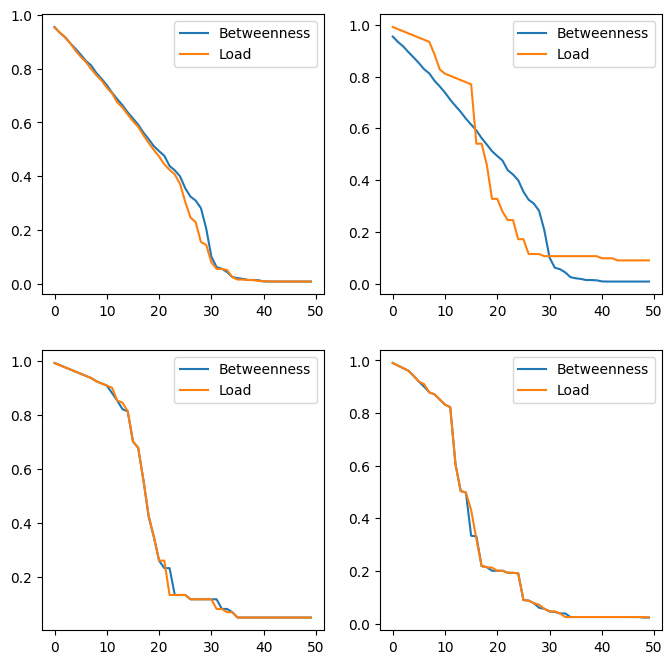

In [78]:
#plot load and betweenness attack
figure = plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.plot(list(bet_attack_arenas_email[0].keys()), list(bet_attack_arenas_email[0].values()), label='Betweenness')
plt.plot(list(load_attack_arenas_email[0].keys()), list(load_attack_arenas_email[0].values()), label='Load')
plt.legend()

plt.subplot(2,2,2)
plt.plot(list(bet_attack_circuits_s208[0].keys()), list(bet_attack_circuits_s208[0].values()), label='Betweenness')
plt.plot(list(load_attack_circuits_s208[0].keys()), list(load_attack_circuits_s208[0].values()), label='Load')
plt.legend()

plt.subplot(2,2,3)
plt.plot(list(bet_attack_circuits_s420[0].keys()), list(bet_attack_circuits_s420[0].values()), label='Betweenness')
plt.plot(list(load_attack_circuits_s420[0].keys()), list(load_attack_circuits_s420[0].values()), label='Load')
plt.legend()

plt.subplot(2,2,4)
plt.plot(list(bet_attack_circuits_s838[0].keys()), list(bet_attack_circuits_s838[0].values()), label='Betweenness')
plt.plot(list(load_attack_circuits_s838[0].keys()), list(load_attack_circuits_s838[0].values()), label='Load')
plt.legend()

#### checkpoint: save .csv files

In [61]:
data_frame_lcc = pd.DataFrame(columns=['network', 'betweeness', 'closeness','degree', 'plci', 'percolation','proximity','MEB','MEC','MED'])
data_frame_lcc['network'] = ['arenas_email', 'bn_cat_mixed_species_brain_1', 'bn_macaque_rhesus_brain_2', 'circuits_s208', 'circuits_s420', 'circuits_s838', 'e_coli', 'facebook_0', 'facebook_107', 'facebook_1684', 'facebook_348', 'facebook_414', 'facebook_686', 'polbooks', 'word_adjacencies', 'net911', 'corruption', 'crime_net', 'jazz', 'petster_hamster', 'email']
data_frame_lcc['betweeness']=[list(bet_attack_arenas_email[0].values()),list(bet_attack_bn_cat_mixed_species_brain_1[0].values()),list(bet_attack_bn_macaque_rhesus_brain_2[0].values()),list(bet_attack_circuits_s208[0].values()),list(bet_attack_circuits_s420[0].values()),list(bet_attack_circuits_s838[0].values()),list(bet_attack_e_coli[0].values()),list(bet_attack_facebook_0[0].values()),list(bet_attack_facebook_107[0].values()),list(bet_attack_facebook_1684[0].values()),list(bet_attack_facebook_348[0].values()),list(bet_attack_facebook_414[0].values()),list(bet_attack_facebook_686[0].values()),list(bet_attack_polbooks[0].values()),list(bet_attack_word_adjacencies[0].values()),list(bet_attack_net911[0].values()),list(bet_attack_corruption[0].values()),list(bet_attack_crime_net[0].values()),list(bet_attack_jazz[0].values()),list(bet_attack_petster_hamster[0].values()),list(bet_attack_email[0].values())]
data_frame_lcc['closeness']=[list(clos_attack_arenas_email[0].values()), list(clos_attack_bn_cat_mixed_species_brain_1[0].values()), list(clos_attack_bn_macaque_rhesus_brain_2[0].values()), list(clos_attack_circuits_s208[0].values()), list(clos_attack_circuits_s420[0].values()), list(clos_attack_circuits_s838[0].values()), list(clos_attack_e_coli[0].values()), list(clos_attack_facebook_0[0].values()), list(clos_attack_facebook_107[0].values()), list(clos_attack_facebook_1684[0].values()), list(clos_attack_facebook_348[0].values()), list(clos_attack_facebook_414[0].values()), list(clos_attack_facebook_686[0].values()), list(clos_attack_polbooks[0].values()), list(clos_attack_word_adjacencies[0].values()), list(clos_attack_net911[0].values()), list(clos_attack_corruption[0].values()), list(clos_attack_crime_net[0].values()), list(clos_attack_jazz[0].values()), list(clos_attack_petster_hamster[0].values()), list(clos_attack_email[0].values())]
data_frame_lcc['degree']=[list(deg_attack_arenas_email[0].values()), list(deg_attack_bn_cat_mixed_species_brain_1[0].values()), list(deg_attack_bn_macaque_rhesus_brain_2[0].values()), list(deg_attack_circuits_s208[0].values()), list(deg_attack_circuits_s420[0].values()), list(deg_attack_circuits_s838[0].values()), list(deg_attack_e_coli[0].values()), list(deg_attack_facebook_0[0].values()), list(deg_attack_facebook_107[0].values()), list(deg_attack_facebook_1684[0].values()), list(deg_attack_facebook_348[0].values()), list(deg_attack_facebook_414[0].values()), list(deg_attack_facebook_686[0].values()), list(deg_attack_polbooks[0].values()), list(deg_attack_word_adjacencies[0].values()), list(deg_attack_net911[0].values()), list(deg_attack_corruption[0].values()), list(deg_attack_crime_net[0].values()), list(deg_attack_jazz[0].values()), list(deg_attack_petster_hamster[0].values()), list(deg_attack_email[0].values())]
data_frame_lcc['plci']=[list(plci_attack_arenas_email[0].values()), list(plci_attack_bn_cat_mixed_species_brain_1[0].values()), list(plci_attack_bn_macaque_rhesus_brain_2[0].values()), list(plci_attack_circuits_s208[0].values()), list(plci_attack_circuits_s420[0].values()), list(plci_attack_circuits_s838[0].values()), list(plci_attack_e_coli[0].values()), list(plci_attack_facebook_0[0].values()), list(plci_attack_facebook_107[0].values()), list(plci_attack_facebook_1684[0].values()), list(plci_attack_facebook_348[0].values()), list(plci_attack_facebook_414[0].values()), list(plci_attack_facebook_686[0].values()), list(plci_attack_polbooks[0].values()), list(plci_attack_word_adjacencies[0].values()), list(plci_attack_net911[0].values()), list(plci_attack_corruption[0].values()), list(plci_attack_crime_net[0].values()), list(plci_attack_jazz[0].values()), list(plci_attack_petster_hamster[0].values()), list(plci_attack_email[0].values())]
data_frame_lcc['percolation']=[list(percolation_attack_arenas_email[0].values()), list(percolation_attack_bn_cat_mixed_species_brain_1[0].values()), list(percolation_attack_bn_macaque_rhesus_brain_2[0].values()), list(percolation_attack_circuits_s208[0].values()), list(percolation_attack_circuits_s420[0].values()), list(percolation_attack_circuits_s838[0].values()), list(percolation_attack_e_coli[0].values()), list(percolation_attack_facebook_0[0].values()), list(percolation_attack_facebook_107[0].values()), list(percolation_attack_facebook_1684[0].values()), list(percolation_attack_facebook_348[0].values()), list(percolation_attack_facebook_414[0].values()), list(percolation_attack_facebook_686[0].values()), list(percolation_attack_polbooks[0].values()), list(percolation_attack_word_adjacencies[0].values()), list(percolation_attack_net911[0].values()), list(percolation_attack_corruption[0].values()), list(percolation_attack_crime_net[0].values()), list(percolation_attack_jazz[0].values()), list(percolation_attack_petster_hamster[0].values()), list(percolation_attack_email[0].values())]
data_frame_lcc['proximity']=[list(proximity_attack_arenas_email[0].values()), list(proximity_attack_bn_cat_mixed_species_brain_1[0].values()), list(proximity_attack_bn_macaque_rhesus_brain_2[0].values()), list(proximity_attack_circuits_s208[0].values()), list(proximity_attack_circuits_s420[0].values()), list(proximity_attack_circuits_s838[0].values()), list(proximity_attack_e_coli[0].values()), list(proximity_attack_facebook_0[0].values()), list(proximity_attack_facebook_107[0].values()), list(proximity_attack_facebook_1684[0].values()), list(proximity_attack_facebook_348[0].values()), list(proximity_attack_facebook_414[0].values()), list(proximity_attack_facebook_686[0].values()), list(proximity_attack_polbooks[0].values()), list(proximity_attack_word_adjacencies[0].values()), list(proximity_attack_net911[0].values()), list(proximity_attack_corruption[0].values()), list(proximity_attack_crime_net[0].values()), list(proximity_attack_jazz[0].values()), list(proximity_attack_petster_hamster[0].values()), list(proximity_attack_email[0].values())]
data_frame_lcc['MEB']=[list(meb_attack_arenas_email[0].values()), list(meb_attack_bn_cat_mixed_species_brain_1[0].values()), list(meb_attack_bn_macaque_rhesus_brain_2[0].values()), list(meb_attack_circuits_s208[0].values()), list(meb_attack_circuits_s420[0].values()), list(meb_attack_circuits_s838[0].values()), list(meb_attack_e_coli[0].values()), list(meb_attack_facebook_0[0].values()), list(meb_attack_facebook_107[0].values()), list(meb_attack_facebook_1684[0].values()), list(meb_attack_facebook_348[0].values()), list(meb_attack_facebook_414[0].values()), list(meb_attack_facebook_686[0].values()), list(meb_attack_polbooks[0].values()), list(meb_attack_word_adjacencies[0].values()), list(meb_attack_net911[0].values()), list(meb_attack_corruption[0].values()), list(meb_attack_crime_net[0].values()), list(meb_attack_jazz[0].values()), list(meb_attack_petster_hamster[0].values()), list(meb_attack_email[0].values())]
data_frame_lcc['MEC']=[list(mec_attack_arenas_email[0].values()), list(mec_attack_bn_cat_mixed_species_brain_1[0].values()), list(mec_attack_bn_macaque_rhesus_brain_2[0].values()), list(mec_attack_circuits_s208[0].values()), list(mec_attack_circuits_s420[0].values()), list(mec_attack_circuits_s838[0].values()), list(mec_attack_e_coli[0].values()), list(mec_attack_facebook_0[0].values()), list(mec_attack_facebook_107[0].values()), list(mec_attack_facebook_1684[0].values()), list(mec_attack_facebook_348[0].values()), list(mec_attack_facebook_414[0].values()), list(mec_attack_facebook_686[0].values()), list(mec_attack_polbooks[0].values()), list(mec_attack_word_adjacencies[0].values()), list(mec_attack_net911[0].values()), list(mec_attack_corruption[0].values()), list(mec_attack_crime_net[0].values()), list(mec_attack_jazz[0].values()), list(mec_attack_petster_hamster[0].values()), list(mec_attack_email[0].values())]
data_frame_lcc['MED']=[list(med_attack_arenas_email[0].values()), list(med_attack_bn_cat_mixed_species_brain_1[0].values()), list(med_attack_bn_macaque_rhesus_brain_2[0].values()), list(med_attack_circuits_s208[0].values()), list(med_attack_circuits_s420[0].values()), list(med_attack_circuits_s838[0].values()), list(med_attack_e_coli[0].values()), list(med_attack_facebook_0[0].values()), list(med_attack_facebook_107[0].values()), list(med_attack_facebook_1684[0].values()), list(med_attack_facebook_348[0].values()), list(med_attack_facebook_414[0].values()), list(med_attack_facebook_686[0].values()), list(med_attack_polbooks[0].values()), list(med_attack_word_adjacencies[0].values()), list(med_attack_net911[0].values()), list(med_attack_corruption[0].values()), list(med_attack_crime_net[0].values()), list(med_attack_jazz[0].values()), list(med_attack_petster_hamster[0].values()), list(med_attack_email[0].values())]
data_frame_lcc.to_csv('../results/networks_lcc_list.csv', index=False)
data_frame_lcc

#------------------------------------------------------------------------------------------
#now I index
data_frame_inter = pd.DataFrame(columns=['network', 'betweeness', 'closeness','degree', 'plci', 'percolation','proximity','MEB','MEC','MED'])
data_frame_inter['network'] = ['arenas_email', 'bn_cat_mixed_species_brain_1', 'bn_macaque_rhesus_brain_2', 'circuits_s208', 'circuits_s420', 'circuits_s838', 'e_coli', 'facebook_0', 'facebook_107', 'facebook_1684', 'facebook_348', 'facebook_414', 'facebook_686', 'polbooks', 'word_adjacencies', 'net911', 'corruption', 'crime_net', 'jazz', 'petster_hamster', 'email']
data_frame_inter['betweeness']=[list(bet_attack_arenas_email[1].values()),list(bet_attack_bn_cat_mixed_species_brain_1[1].values()),list(bet_attack_bn_macaque_rhesus_brain_2[1].values()),list(bet_attack_circuits_s208[1].values()),list(bet_attack_circuits_s420[1].values()),list(bet_attack_circuits_s838[1].values()),list(bet_attack_e_coli[1].values()),list(bet_attack_facebook_0[1].values()),list(bet_attack_facebook_107[1].values()),list(bet_attack_facebook_1684[1].values()),list(bet_attack_facebook_348[1].values()),list(bet_attack_facebook_414[1].values()),list(bet_attack_facebook_686[1].values()),list(bet_attack_polbooks[1].values()),list(bet_attack_word_adjacencies[1].values()),list(bet_attack_net911[1].values()),list(bet_attack_corruption[1].values()),list(bet_attack_crime_net[1].values()),list(bet_attack_jazz[1].values()),list(bet_attack_petster_hamster[1].values()),list(bet_attack_email[1].values())]
data_frame_inter['closeness']=[list(clos_attack_arenas_email[1].values()), list(clos_attack_bn_cat_mixed_species_brain_1[1].values()), list(clos_attack_bn_macaque_rhesus_brain_2[1].values()), list(clos_attack_circuits_s208[1].values()), list(clos_attack_circuits_s420[1].values()), list(clos_attack_circuits_s838[1].values()), list(clos_attack_e_coli[1].values()), list(clos_attack_facebook_0[1].values()), list(clos_attack_facebook_107[1].values()), list(clos_attack_facebook_1684[1].values()), list(clos_attack_facebook_348[1].values()), list(clos_attack_facebook_414[1].values()), list(clos_attack_facebook_686[1].values()), list(clos_attack_polbooks[1].values()), list(clos_attack_word_adjacencies[1].values()), list(clos_attack_net911[1].values()), list(clos_attack_corruption[1].values()), list(clos_attack_crime_net[1].values()), list(clos_attack_jazz[1].values()), list(clos_attack_petster_hamster[1].values()), list(clos_attack_email[1].values())]
data_frame_inter['degree']=[list(deg_attack_arenas_email[1].values()), list(deg_attack_bn_cat_mixed_species_brain_1[1].values()), list(deg_attack_bn_macaque_rhesus_brain_2[1].values()), list(deg_attack_circuits_s208[1].values()), list(deg_attack_circuits_s420[1].values()), list(deg_attack_circuits_s838[1].values()), list(deg_attack_e_coli[1].values()), list(deg_attack_facebook_0[1].values()), list(deg_attack_facebook_107[1].values()), list(deg_attack_facebook_1684[1].values()), list(deg_attack_facebook_348[1].values()), list(deg_attack_facebook_414[1].values()), list(deg_attack_facebook_686[1].values()), list(deg_attack_polbooks[1].values()), list(deg_attack_word_adjacencies[1].values()), list(deg_attack_net911[1].values()), list(deg_attack_corruption[1].values()), list(deg_attack_crime_net[1].values()), list(deg_attack_jazz[1].values()), list(deg_attack_petster_hamster[1].values()), list(deg_attack_email[1].values())]
data_frame_inter['plci']=[list(plci_attack_arenas_email[1].values()), list(plci_attack_bn_cat_mixed_species_brain_1[1].values()), list(plci_attack_bn_macaque_rhesus_brain_2[1].values()), list(plci_attack_circuits_s208[1].values()), list(plci_attack_circuits_s420[1].values()), list(plci_attack_circuits_s838[1].values()), list(plci_attack_e_coli[1].values()), list(plci_attack_facebook_0[1].values()), list(plci_attack_facebook_107[1].values()), list(plci_attack_facebook_1684[1].values()), list(plci_attack_facebook_348[1].values()), list(plci_attack_facebook_414[1].values()), list(plci_attack_facebook_686[1].values()), list(plci_attack_polbooks[1].values()), list(plci_attack_word_adjacencies[1].values()), list(plci_attack_net911[1].values()), list(plci_attack_corruption[1].values()), list(plci_attack_crime_net[1].values()), list(plci_attack_jazz[1].values()), list(plci_attack_petster_hamster[1].values()), list(plci_attack_email[1].values())]
data_frame_inter['percolation']=[list(percolation_attack_arenas_email[1].values()), list(percolation_attack_bn_cat_mixed_species_brain_1[1].values()), list(percolation_attack_bn_macaque_rhesus_brain_2[1].values()), list(percolation_attack_circuits_s208[1].values()), list(percolation_attack_circuits_s420[1].values()), list(percolation_attack_circuits_s838[1].values()), list(percolation_attack_e_coli[1].values()), list(percolation_attack_facebook_0[1].values()), list(percolation_attack_facebook_107[1].values()), list(percolation_attack_facebook_1684[1].values()), list(percolation_attack_facebook_348[1].values()), list(percolation_attack_facebook_414[1].values()), list(percolation_attack_facebook_686[1].values()), list(percolation_attack_polbooks[1].values()), list(percolation_attack_word_adjacencies[1].values()), list(percolation_attack_net911[1].values()), list(percolation_attack_corruption[1].values()), list(percolation_attack_crime_net[1].values()), list(percolation_attack_jazz[1].values()), list(percolation_attack_petster_hamster[1].values()), list(percolation_attack_email[1].values())]
data_frame_inter['proximity']=[list(proximity_attack_arenas_email[1].values()), list(proximity_attack_bn_cat_mixed_species_brain_1[1].values()), list(proximity_attack_bn_macaque_rhesus_brain_2[1].values()), list(proximity_attack_circuits_s208[1].values()), list(proximity_attack_circuits_s420[1].values()), list(proximity_attack_circuits_s838[1].values()), list(proximity_attack_e_coli[1].values()), list(proximity_attack_facebook_0[1].values()), list(proximity_attack_facebook_107[1].values()), list(proximity_attack_facebook_1684[1].values()), list(proximity_attack_facebook_348[1].values()), list(proximity_attack_facebook_414[1].values()), list(proximity_attack_facebook_686[1].values()), list(proximity_attack_polbooks[1].values()), list(proximity_attack_word_adjacencies[1].values()), list(proximity_attack_net911[1].values()), list(proximity_attack_corruption[1].values()), list(proximity_attack_crime_net[1].values()), list(proximity_attack_jazz[1].values()), list(proximity_attack_petster_hamster[1].values()), list(proximity_attack_email[1].values())]
data_frame_inter['MEB']=[list(meb_attack_arenas_email[1].values()), list(meb_attack_bn_cat_mixed_species_brain_1[1].values()), list(meb_attack_bn_macaque_rhesus_brain_2[1].values()), list(meb_attack_circuits_s208[1].values()), list(meb_attack_circuits_s420[1].values()), list(meb_attack_circuits_s838[1].values()), list(meb_attack_e_coli[1].values()), list(meb_attack_facebook_0[1].values()), list(meb_attack_facebook_107[1].values()), list(meb_attack_facebook_1684[1].values()), list(meb_attack_facebook_348[1].values()), list(meb_attack_facebook_414[1].values()), list(meb_attack_facebook_686[1].values()), list(meb_attack_polbooks[1].values()), list(meb_attack_word_adjacencies[1].values()), list(meb_attack_net911[1].values()), list(meb_attack_corruption[1].values()), list(meb_attack_crime_net[1].values()), list(meb_attack_jazz[1].values()), list(meb_attack_petster_hamster[1].values()), list(meb_attack_email[1].values())]
data_frame_inter['MEC']=[list(mec_attack_arenas_email[1].values()), list(mec_attack_bn_cat_mixed_species_brain_1[1].values()), list(mec_attack_bn_macaque_rhesus_brain_2[1].values()), list(mec_attack_circuits_s208[1].values()), list(mec_attack_circuits_s420[1].values()), list(mec_attack_circuits_s838[1].values()), list(mec_attack_e_coli[1].values()), list(mec_attack_facebook_0[1].values()), list(mec_attack_facebook_107[1].values()), list(mec_attack_facebook_1684[1].values()), list(mec_attack_facebook_348[1].values()), list(mec_attack_facebook_414[1].values()), list(mec_attack_facebook_686[1].values()), list(mec_attack_polbooks[1].values()), list(mec_attack_word_adjacencies[1].values()), list(mec_attack_net911[1].values()), list(mec_attack_corruption[1].values()), list(mec_attack_crime_net[1].values()), list(mec_attack_jazz[1].values()), list(mec_attack_petster_hamster[1].values()), list(mec_attack_email[1].values())]
data_frame_inter['MED']=[list(med_attack_arenas_email[1].values()), list(med_attack_bn_cat_mixed_species_brain_1[1].values()), list(med_attack_bn_macaque_rhesus_brain_2[1].values()), list(med_attack_circuits_s208[1].values()), list(med_attack_circuits_s420[1].values()), list(med_attack_circuits_s838[1].values()), list(med_attack_e_coli[1].values()), list(med_attack_facebook_0[1].values()), list(med_attack_facebook_107[1].values()), list(med_attack_facebook_1684[1].values()), list(med_attack_facebook_348[1].values()), list(med_attack_facebook_414[1].values()), list(med_attack_facebook_686[1].values()), list(med_attack_polbooks[1].values()), list(med_attack_word_adjacencies[1].values()), list(med_attack_net911[1].values()), list(med_attack_corruption[1].values()), list(med_attack_crime_net[1].values()), list(med_attack_jazz[1].values()), list(med_attack_petster_hamster[1].values()), list(med_attack_email[1].values())]
data_frame_inter.to_csv('../results/networks_inter_list.csv', index=False)
data_frame_inter

#------------------------------------------------------------------------------------------
#now global efficiency
data_frame_eff = pd.DataFrame(columns=['network', 'betweeness', 'closeness','degree', 'plci', 'percolation','proximity','MEB','MEC','MED'])
data_frame_eff['network'] = ['arenas_email', 'bn_cat_mixed_species_brain_1', 'bn_macaque_rhesus_brain_2', 'circuits_s208', 'circuits_s420', 'circuits_s838', 'e_coli', 'facebook_0', 'facebook_107', 'facebook_1684', 'facebook_348', 'facebook_414', 'facebook_686', 'polbooks', 'word_adjacencies', 'net911', 'corruption', 'crime_net', 'jazz', 'petster_hamster', 'email']
data_frame_eff['betweeness']=[list(bet_attack_arenas_email[2].values()),list(bet_attack_bn_cat_mixed_species_brain_1[2].values()),list(bet_attack_bn_macaque_rhesus_brain_2[2].values()),list(bet_attack_circuits_s208[2].values()),list(bet_attack_circuits_s420[2].values()),list(bet_attack_circuits_s838[2].values()),list(bet_attack_e_coli[2].values()),list(bet_attack_facebook_0[2].values()),list(bet_attack_facebook_107[2].values()),list(bet_attack_facebook_1684[2].values()),list(bet_attack_facebook_348[2].values()),list(bet_attack_facebook_414[2].values()),list(bet_attack_facebook_686[2].values()),list(bet_attack_polbooks[2].values()),list(bet_attack_word_adjacencies[2].values()),list(bet_attack_net911[2].values()),list(bet_attack_corruption[2].values()),list(bet_attack_crime_net[2].values()),list(bet_attack_jazz[2].values()),list(bet_attack_petster_hamster[2].values()),list(bet_attack_email[2].values())]
data_frame_eff['closeness']=[list(clos_attack_arenas_email[2].values()), list(clos_attack_bn_cat_mixed_species_brain_1[2].values()), list(clos_attack_bn_macaque_rhesus_brain_2[2].values()), list(clos_attack_circuits_s208[2].values()), list(clos_attack_circuits_s420[2].values()), list(clos_attack_circuits_s838[2].values()), list(clos_attack_e_coli[2].values()), list(clos_attack_facebook_0[2].values()), list(clos_attack_facebook_107[2].values()), list(clos_attack_facebook_1684[2].values()), list(clos_attack_facebook_348[2].values()), list(clos_attack_facebook_414[2].values()), list(clos_attack_facebook_686[2].values()), list(clos_attack_polbooks[2].values()), list(clos_attack_word_adjacencies[2].values()), list(clos_attack_net911[2].values()), list(clos_attack_corruption[2].values()), list(clos_attack_crime_net[2].values()), list(clos_attack_jazz[2].values()), list(clos_attack_petster_hamster[2].values()), list(clos_attack_email[2].values())]
data_frame_eff['degree']=[list(deg_attack_arenas_email[2].values()), list(deg_attack_bn_cat_mixed_species_brain_1[2].values()), list(deg_attack_bn_macaque_rhesus_brain_2[2].values()), list(deg_attack_circuits_s208[2].values()), list(deg_attack_circuits_s420[2].values()), list(deg_attack_circuits_s838[2].values()), list(deg_attack_e_coli[2].values()), list(deg_attack_facebook_0[2].values()), list(deg_attack_facebook_107[2].values()), list(deg_attack_facebook_1684[2].values()), list(deg_attack_facebook_348[2].values()), list(deg_attack_facebook_414[2].values()), list(deg_attack_facebook_686[2].values()), list(deg_attack_polbooks[2].values()), list(deg_attack_word_adjacencies[2].values()), list(deg_attack_net911[2].values()), list(deg_attack_corruption[2].values()), list(deg_attack_crime_net[2].values()), list(deg_attack_jazz[2].values()), list(deg_attack_petster_hamster[2].values()), list(deg_attack_email[2].values())]
data_frame_eff['plci']=[list(plci_attack_arenas_email[2].values()), list(plci_attack_bn_cat_mixed_species_brain_1[2].values()), list(plci_attack_bn_macaque_rhesus_brain_2[2].values()), list(plci_attack_circuits_s208[2].values()), list(plci_attack_circuits_s420[2].values()), list(plci_attack_circuits_s838[2].values()), list(plci_attack_e_coli[2].values()), list(plci_attack_facebook_0[2].values()), list(plci_attack_facebook_107[2].values()), list(plci_attack_facebook_1684[2].values()), list(plci_attack_facebook_348[2].values()), list(plci_attack_facebook_414[2].values()), list(plci_attack_facebook_686[2].values()), list(plci_attack_polbooks[2].values()), list(plci_attack_word_adjacencies[2].values()), list(plci_attack_net911[2].values()), list(plci_attack_corruption[2].values()), list(plci_attack_crime_net[2].values()), list(plci_attack_jazz[2].values()), list(plci_attack_petster_hamster[2].values()), list(plci_attack_email[2].values())]
data_frame_eff['percolation']=[list(percolation_attack_arenas_email[2].values()), list(percolation_attack_bn_cat_mixed_species_brain_1[2].values()), list(percolation_attack_bn_macaque_rhesus_brain_2[2].values()), list(percolation_attack_circuits_s208[2].values()), list(percolation_attack_circuits_s420[2].values()), list(percolation_attack_circuits_s838[2].values()), list(percolation_attack_e_coli[2].values()), list(percolation_attack_facebook_0[2].values()), list(percolation_attack_facebook_107[2].values()), list(percolation_attack_facebook_1684[2].values()), list(percolation_attack_facebook_348[2].values()), list(percolation_attack_facebook_414[2].values()), list(percolation_attack_facebook_686[2].values()), list(percolation_attack_polbooks[2].values()), list(percolation_attack_word_adjacencies[2].values()), list(percolation_attack_net911[2].values()), list(percolation_attack_corruption[2].values()), list(percolation_attack_crime_net[2].values()), list(percolation_attack_jazz[2].values()), list(percolation_attack_petster_hamster[2].values()), list(percolation_attack_email[2].values())]
data_frame_eff['proximity']=[list(proximity_attack_arenas_email[2].values()), list(proximity_attack_bn_cat_mixed_species_brain_1[2].values()), list(proximity_attack_bn_macaque_rhesus_brain_2[2].values()), list(proximity_attack_circuits_s208[2].values()), list(proximity_attack_circuits_s420[2].values()), list(proximity_attack_circuits_s838[2].values()), list(proximity_attack_e_coli[2].values()), list(proximity_attack_facebook_0[2].values()), list(proximity_attack_facebook_107[2].values()), list(proximity_attack_facebook_1684[2].values()), list(proximity_attack_facebook_348[2].values()), list(proximity_attack_facebook_414[2].values()), list(proximity_attack_facebook_686[2].values()), list(proximity_attack_polbooks[2].values()), list(proximity_attack_word_adjacencies[2].values()), list(proximity_attack_net911[2].values()), list(proximity_attack_corruption[2].values()), list(proximity_attack_crime_net[2].values()), list(proximity_attack_jazz[2].values()), list(proximity_attack_petster_hamster[2].values()), list(proximity_attack_email[2].values())]
data_frame_eff['MEB']=[list(meb_attack_arenas_email[2].values()), list(meb_attack_bn_cat_mixed_species_brain_1[2].values()), list(meb_attack_bn_macaque_rhesus_brain_2[2].values()), list(meb_attack_circuits_s208[2].values()), list(meb_attack_circuits_s420[2].values()), list(meb_attack_circuits_s838[2].values()), list(meb_attack_e_coli[2].values()), list(meb_attack_facebook_0[2].values()), list(meb_attack_facebook_107[2].values()), list(meb_attack_facebook_1684[2].values()), list(meb_attack_facebook_348[2].values()), list(meb_attack_facebook_414[2].values()), list(meb_attack_facebook_686[2].values()), list(meb_attack_polbooks[2].values()), list(meb_attack_word_adjacencies[2].values()), list(meb_attack_net911[2].values()), list(meb_attack_corruption[2].values()), list(meb_attack_crime_net[2].values()), list(meb_attack_jazz[2].values()), list(meb_attack_petster_hamster[2].values()), list(meb_attack_email[2].values())]
data_frame_eff['MEC']=[list(mec_attack_arenas_email[2].values()), list(mec_attack_bn_cat_mixed_species_brain_1[2].values()), list(mec_attack_bn_macaque_rhesus_brain_2[2].values()), list(mec_attack_circuits_s208[2].values()), list(mec_attack_circuits_s420[2].values()), list(mec_attack_circuits_s838[2].values()), list(mec_attack_e_coli[2].values()), list(mec_attack_facebook_0[2].values()), list(mec_attack_facebook_107[2].values()), list(mec_attack_facebook_1684[2].values()), list(mec_attack_facebook_348[2].values()), list(mec_attack_facebook_414[2].values()), list(mec_attack_facebook_686[2].values()), list(mec_attack_polbooks[2].values()), list(mec_attack_word_adjacencies[2].values()), list(mec_attack_net911[2].values()), list(mec_attack_corruption[2].values()), list(mec_attack_crime_net[2].values()), list(mec_attack_jazz[2].values()), list(mec_attack_petster_hamster[2].values()), list(mec_attack_email[2].values())]
data_frame_eff['MED']=[list(med_attack_arenas_email[2].values()), list(med_attack_bn_cat_mixed_species_brain_1[2].values()), list(med_attack_bn_macaque_rhesus_brain_2[2].values()), list(med_attack_circuits_s208[2].values()), list(med_attack_circuits_s420[2].values()), list(med_attack_circuits_s838[2].values()), list(med_attack_e_coli[2].values()), list(med_attack_facebook_0[2].values()), list(med_attack_facebook_107[2].values()), list(med_attack_facebook_1684[2].values()), list(med_attack_facebook_348[2].values()), list(med_attack_facebook_414[2].values()), list(med_attack_facebook_686[2].values()), list(med_attack_polbooks[2].values()), list(med_attack_word_adjacencies[2].values()), list(med_attack_net911[2].values()), list(med_attack_corruption[2].values()), list(med_attack_crime_net[2].values()), list(med_attack_jazz[2].values()), list(med_attack_petster_hamster[2].values()), list(med_attack_email[2].values())]
data_frame_eff.to_csv('../results/networks_eff_list.csv', index=False)
data_frame_eff

,network,betweeness,closeness,degree,plci,percolation,proximity,MEB,MEC,MED
0,arenas_email,"[0.19635336207253276, 0.18435340419315172, 0.1...","[0.19830517157353364, 0.19040945121527966, 0.1...","[0.1954950767443035, 0.18263397669254394, 0.17...","[0.20827421949405173, 0.20641648223098222, 0.2...","[0.19644929323950813, 0.18430226485490242, 0.1...","[0.2099386776033955, 0.20991095905243545, 0.20...","[0.1979072620414358, 0.1932602872330214, 0.189...","[0.19448707398469028, 0.18271337942750648, 0.1...","[0.19535379065061048, 0.18756550591524804, 0.1..."
1,bn_cat_mixed_species_brain_1,"[0.48743540051675127, 0.48165805446189836, 0.4...","[0.48817829457359785, 0.48432988845139957, 0.4...","[0.48817829457359785, 0.48432988845139957, 0.4...","[0.48743540051675127, 0.48655060695533703, 0.4...","[0.48880410206713876, 0.48707964238840695, 0.4...","[0.48817829457359785, 0.48432988845139957, 0.4...","[0.4905805878552523, 0.4883304625983819, 0.484...","[0.48743540051675127, 0.48165805446189836, 0.4...","[0.48743540051675127, 0.48165805446189836, 0.4..."
2,bn_macaque_rhesus_brain_2,"[0.5265181518151782, 0.4832491582491574, 0.464...","[0.5265181518151782, 0.4832491582491574, 0.464...","[0.5265181518151782, 0.4832491582491574, 0.464...","[0.5466501650164978, 0.5480303030302995, 0.547...","[0.5462541254125378, 0.5455387205387177, 0.541...","[0.5265181518151782, 0.4832491582491574, 0.464...","[0.5265181518151782, 0.5256060606060581, 0.519...","[0.5265181518151782, 0.4832491582491574, 0.466...","[0.5265181518151782, 0.520420875420873, 0.5150..."
3,circuits_s208,"[0.19635336207253276, 0.18435340419315172, 0.1...","[0.23118702272627661, 0.20939890602705952, 0.1...","[0.23284596257736437, 0.20939890602705952, 0.2...","[0.23891667064187447, 0.23695724249295463, 0.2...","[0.23284596257736437, 0.2101799690350099, 0.19...","[0.23118702272627661, 0.20939890602705952, 0.1...","[0.24480496126156479, 0.23637881415191778, 0.2...","[0.23284596257736437, 0.2246782046151778, 0.20...","[0.24480496126156479, 0.23637881415191778, 0.2..."
4,circuits_s420,"[0.17625178248796644, 0.16594453842564094, 0.1...","[0.17625178248796644, 0.16594453842564094, 0.1...","[0.17736190003662683, 0.16927160747196232, 0.1...","[0.20133837880103084, 0.18545210331078446, 0.1...","[0.17625178248796644, 0.15684385415643143, 0.1...","[0.17625178248796644, 0.16594453842564094, 0.1...","[0.19955933303644535, 0.19806238629537812, 0.1...","[0.1890883546618552, 0.17755352741885658, 0.17...","[0.19086715239245766, 0.1775155518846034, 0.17..."
5,circuits_s838,"[0.13726501697865925, 0.12631596111674517, 0.1...","[0.13610094670676784, 0.13381734983093263, 0.1...","[0.14537169176947334, 0.14104664391333618, 0.1...","[0.16321325702401018, 0.16106137180503952, 0.1...","[0.13456782175287438, 0.11262495052655876, 0.1...","[0.13610094670676784, 0.13381734983093263, 0.1...","[0.16751920904142095, 0.16538892195587296, 0.1...","[0.14915811637650495, 0.1453514969826645, 0.14...","[0.15053780501794245, 0.14626776110402243, 0.1..."
6,e_coli,"[0.03886282854028239, 0.010354378637174758, 0....","[0.1677177059387689, 0.1441189684933956, 0.118...","[0.03231247821285814, 0.003703929034169234, 0....","[0.24334847692267084, 0.24172166595392403, 0.2...","[0.2345655618905862, 0.23835581022809585, 0.24...","[0.24391010394444534, 0.24786830834551998, 0.2...","[0.1692681427035711, 0.1656237845835003, 0.140...","[0.032441500619890054, 0.004229741590453269, 0...","[0.09331735392359668, 0.034229991762081725, 0...."
7,facebook_0,"[0.2955324983676288, 0.25866035112251046, 0.21...","[0.3009453393925375, 0.29202344546392073, 0.28...","[0.31635238023468615, 0.3072083595160985, 0.29...","[0.32138097710218233, 0.32181271191657157, 0.3...","[0.3176444586392219, 0.3160317592974111, 0.313...","[0.3176444586392219, 0.3160317592974111, 0.313...","[0.3176444586392219, 0.3139540711275298, 0.311...","[0.3137434131576289, 0.30969488185119065, 0.29...","[0.31677725424618586, 0.31335165233971124, 0.3..."
8,facebook_107,"[0.3701468606102109,

#### Edge centralities:

## community based attack

In [ ]:
def get_boundary_nodes(G, partition):   
    '''takes graph and partiton - list of sets of nodes - as input and returns the boundary nodes in a list'''
    boundary_edges = set()
    for i in range(len(partition)):
        for j in range(len(partition)):
            if i != j:
                boundary_edges.update(nx.edge_boundary(G, partition[i], partition[j]))

    b_nodes = []
    for i in range(len(boundary_edges)):
        b_nodes.append(list(boundary_edges)[i][0])
        b_nodes.append(list(boundary_edges)[i][1])
    b_nodes = list(set(b_nodes))
    return b_nodes



# test

In [34]:


def get_MEB(G:nx.Graph, k:int, bet:dict)->float:
    '''
    takes a graph and a node k, returns the MEB centrality following this formula:
    MEBk= BCk * SUM(log(BCi)) for all i neighbor of k
    '''
    BCk = bet[k][1]
    neighbors = list(G.neighbors(k))
    BC_neighbors = [bet[x][1] for x in neighbors]
    sum_log_BC_neighbors = sum([math.log(x+1e-06) for x in BC_neighbors]) #if betweeness is 0, consider log(0)=-50
    MEBk = - BCk * sum_log_BC_neighbors
    return MEBk

def MEB_centrality(G:nx.Graph, bet)->dict:
    '''takes a graph and returns a dictionary of MEB centrality for each node'''
    MEB = {}
    for node in G.nodes():
        MEB[node] = get_MEB(G, node, bet)
    return MEB

# meb_sorted_circuits_s208 = sorted(MEB_centrality(circuits_s208, betweenness_centrality_sorted_circuits_s208).items(), key=lambda x: x[1], reverse=True)
# meb_sorted_circuits_s208_nodes =[x[0] for x in meb_sorted_circuits_s208]
# meb_attack_circuits_s208 = attack(circuits_s208, meb_sorted_circuits_s208_nodes)
# betweenness_centrality_sorted_circuits_s208 = sorted(nx.betweenness_centrality(circuits_s208, endpoints=True).items(), key=lambda x: x[1], reverse=True)
# bet_attack_circuits_s208 = attack(arenas_email, [x[0] for x in betweenness_centrality_sorted_arenas_email])

#same for polbooks
# betweenness_centrality_sorted_polbooks = sorted(nx.betweenness_centrality(polbooks).items(), key=lambda x: x[1], reverse=True)
# bet_attack_polbooks = attack(arenas_email, [x[0] for x in betweenness_centrality_sorted_arenas_email])
# meb_sorted_polbooks = sorted(MEB_centrality(polbooks, betweenness_centrality_sorted_polbooks).items(), key=lambda x: x[1], reverse=True)
# meb_sorted_polbooks_nodes =[x[0] for x in meb_sorted_polbooks]
# meb_attack_polbooks = attack(polbooks, meb_sorted_polbooks_nodes)


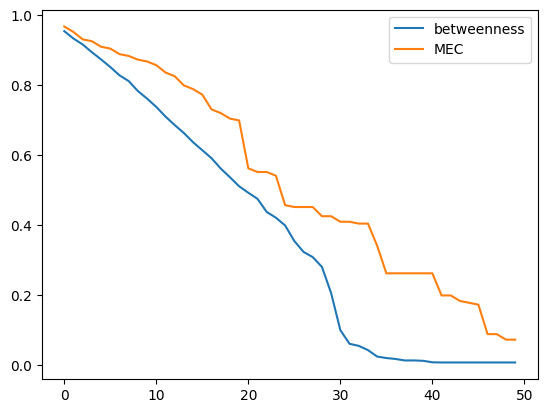

In [58]:
#plot meb attack with betwenees on polbooks
plt.plot(list(bet_attack_polbooks[0].values()), label='betweenness')
plt.plot(list(mec_attack_polbooks[0].values()), label='MEC')
plt.legend()
plt.show()

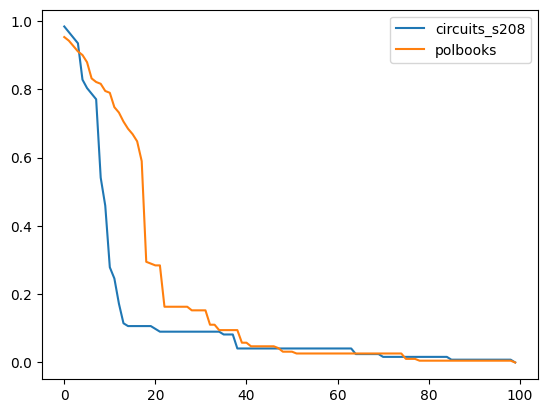

In [96]:
def partition_list(input_list, num=100):
    n = len(input_list) // num
    remainder = len(input_list) % num
    partitions = []
    for i in range(num):
        start = i * n + min(i, remainder)
        end = start + n + (i < remainder)
        partitions.append(input_list[start:end])
    return partitions

def attack_pro(g, sorted_nodes, batch_num=100):
    G=g.copy()  
    N=G.number_of_nodes()
    pi = partition_list(sorted_nodes, batch_num)
    # print(len(pi))

    lcc=0;norm_lcc=0;i_index=0;e=0
    norm_LCC={};LCC={};Inter={};E={}
    R=[]; InterE=[]

    t=time.time()

    for batch in range((len(pi))): #looping through each batch
        for node in pi[batch]:
            G.remove_node(node)
            lcc = compute_lcc(G)
            i_index= compute_i(G, N)
            norm_lcc = lcc/N
            e = nx.algorithms.global_efficiency(G)

            R.append(norm_lcc)
            InterE.append(e)

        norm_LCC[batch]=norm_lcc
        LCC[batch]=lcc
        Inter[batch]=i_index
        E[batch]=e

    e=time.time()
    t=e-t

    #R at halftime doesn not hold according to formula
    R=sum(R)/len(R)
    InterE=sum(InterE)/len(InterE)

    return norm_LCC, Inter, E, R, InterE, t

bet_pro_attack_circuits_s208 = attack_pro(circuits_s208, [x[0] for x in betweenness_centrality_sorted_circuits_s208])
bet_pro_attack_polbooks = attack_pro(polbooks, [x[0] for x in betweenness_centrality_sorted_polbooks])

#plot both networks on LCC
plt.plot(list(bet_pro_attack_circuits_s208[0].values()), label='circuits_s208')
plt.plot(list(bet_pro_attack_polbooks[0].values()), label='polbooks')
plt.legend()

In [106]:
def get_boundary_nodes(G, partition):   
    '''takes graph and partiton - list of sets of nodes - as input and returns the boundary nodes in a list'''
    boundary_edges = set()
    for i in range(len(partition)):
        for j in range(len(partition)):
            if i != j:
                boundary_edges.update(nx.edge_boundary(G, partition[i], partition[j]))

    b_nodes = []
    for i in range(len(boundary_edges)):
        b_nodes.append(list(boundary_edges)[i][0])
        b_nodes.append(list(boundary_edges)[i][1])
    b_nodes = list(set(b_nodes))
    return b_nodes


# def community_attack(g:nx.Graph, partition:list, sorted_central:list):
#     '''
#     take a graph, the partition done after using a community based algorithm, and a list of nodes sorted based on their centrality
#     returns: dictionaries where keys are the number of nodes removed and values are the LCCs normalized/efficiency...
#     '''
#     #stopping criteria is either LCC=0 or boundary nodes left are {}
#     G=g.copy()

#     boundary_nodes = get_boundary_nodes(g, partition)
#     B=len(boundary_nodes ); N=G.number_of_nodes()

#     LCC={}
#     Inter={}
#     Eff={}
#     R=[]
#     sorted_central_q=sorted_central.copy()  

#     for i in range(N): #looping through all nodes
#         if len(boundary_nodes) !=0:
#             if sorted_central[i] in boundary_nodes:
#                 G.remove(sorted_central[i])
#                 sorted_central_q.remove(sorted_central[i])
#                 boundary_nodes.remove(sorted_central[i])
#                 B-=1
#             else: 
#                 continue
#         else: #now we have N-B nodes left in the queue
#             G.remove(sorted_central_q[0]) #they're sorted and everytime im removing the first one
#             sorted_central_q.remove(sorted_central_q[0])
#         lcc = compute_lcc(G)
#         i_index= compute_i(G, N)
        # eff = 

def sort_bounded(sorted_list, boundary_list):
    '''
    takes a sorted list and a list of boundary nodes and returns a sorted list where the boundary nodes are at the start
    '''
    new_list=[]
    sorted_list_q=sorted_list.copy()
    for i in range(len(sorted_list)):
        if sorted_list[i] in boundary_list:
            new_list.append(sorted_list[i])
            sorted_list_q.remove(sorted_list[i])
        else:
            continue
    for i in range(len(sorted_list_q)):
        new_list.append(sorted_list_q[i])
        return new_list

#WITHOUT RECALCULATION  
def community_attack_pro(g:nx.Graph, partition:list, sorted_central:list, batch_num=100):
    '''
    take a graph, the partition done after using a community based algorithm, and a list of nodes sorted based on their centrality
    returns: dictionaries where keys are the number of nodes removed and values are the LCCs normalized/efficiency...
    '''
    #stopping criteria is either LCC=0 or boundary nodes left are {}
    G=g.copy()  
    N=G.number_of_nodes()
    boundary_nodes=get_boundary_nodes(g, partition)
    sorted_list = sort_bounded(sorted_central, boundary_nodes)
    pi = partition_list(sorted_list, batch_num)

    lcc=0;norm_lcc=0;i_index=0;e=0
    norm_LCC={};LCC={};Inter={};E={}
    R=[]; InterE=[]

    t=time.time()

    for batch in range((len(pi))): #looping through each batch
        for node in pi[batch]:
            G.remove_node(node)
            lcc = compute_lcc(G)
            i_index= compute_i(G, N)
            norm_lcc = lcc/N
            e = nx.algorithms.global_efficiency(G)

            R.append(norm_lcc)
            InterE.append(e)

        norm_LCC[batch]=norm_lcc
        LCC[batch]=lcc
        Inter[batch]=i_index
        E[batch]=e

    e=time.time()
    t=e-t

    #R at halftime doesn not hold according to formula
    R=sum(R)/len(R)
    InterE=sum(InterE)/len(InterE)

    return norm_LCC, Inter, E, R, InterE, t 

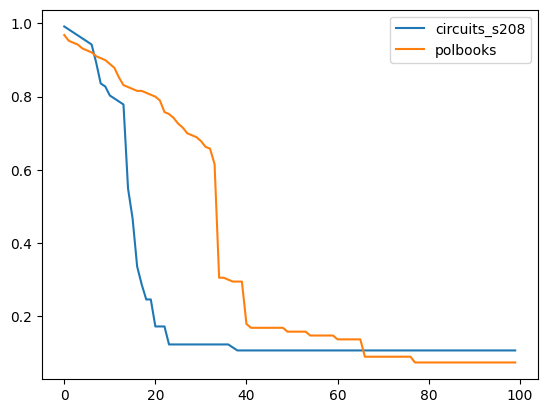

In [109]:
louvain_circuits_s208 = nx.community.louvain_communities(circuits_s208, seed=42)
louvain_polbooks = nx.community.louvain_communities(polbooks, seed=42)

bet_community_attack_circuits_s208 = community_attack_pro(circuits_s208, louvain_circuits_s208, [x[0] for x in betweenness_centrality_sorted_circuits_s208])
bet_community_attack_polbooks = community_attack_pro(polbooks, louvain_polbooks, [x[0] for x in betweenness_centrality_sorted_polbooks])

#plot the LCC
plt.plot(list(bet_community_attack_circuits_s208[0].values()), label='circuits_s208')
plt.plot(list(bet_community_attack_polbooks[0].values()), label='polbooks')
plt.legend()

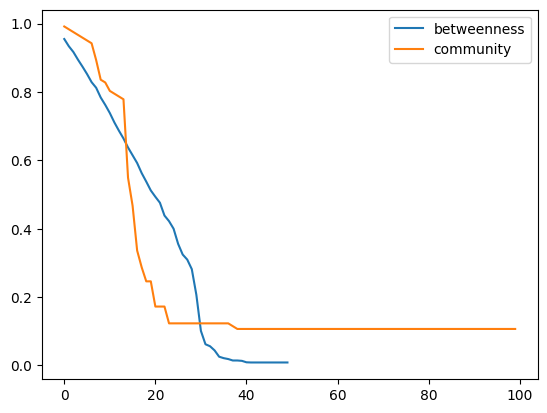

In [110]:
# compare centrality targeted attacks with community based attacks
plt.plot(list(bet_attack_circuits_s208[0].values()), label='betweenness')
plt.plot(list(bet_community_attack_circuits_s208[0].values()), label='community')
plt.legend()